<a href="https://colab.research.google.com/github/Slautin/2025_GP_BO_Manifolds/blob/main/ManifoldBO_VS_SequentialBO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Manifold Bayesian Optimization vs. Sequential Bayesian Optimization

Analysis notebook accompanying the manuscript:
“Sequential versus Manifold Bayesian Optimization under Realistic Experimental Time Constraints”

B. Slautin, S. Kalinin

*January 2026*


In [ ]:
!pip install -U botorch gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.8/287.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


import torch
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
import gpytorch

import io
import imageio.v2 as imageio
from PIL import Image

from skimage import measure

from IPython.display import Image as IPyImage, display

In [ ]:
def sample_random_peak_centers(N, K, rng):
    """
    Random peak centers in the N-dimensional simplex.
    Shape: (K, N)
    """
    x = rng.random((K, N))
    mus = x / x.sum(axis=1, keepdims=True)   # normalize to simplex
    return mus

def property_f_vectorized(C, mus, amplitudes, sigma, noise_std=0.0, rng=None):
    """
    Evaluate Gaussian mixture property landscape at points C (M,N).
    """
    if rng is None:
        rng = np.random.default_rng()

    # C: (M,N), mus: (K,N)
    diff = C[:, None, :] - mus[None, :, :]     # (M,K,N)
    dist2 = np.sum(diff**2, axis=2)            # (M,K)

    gauss = np.exp(-0.5 * dist2 / sigma**2)    # (M,K)

    values = gauss @ amplitudes                # (M,)

    if noise_std > 0:
        values += rng.normal(0, noise_std, size=C.shape[0])

    return values


def make_random_property_function(N, K=50, sigma=0.1,
                                  amp_scale=1.0, noise_std=0.0, seed=None):
    """
    Creates a closure that returns property values for compositions.

    Returns
    -------
    f : callable
        f(C) computes property values for compositions C (M,N).

    Notes
    -----
    - Centers, amplitudes, and RNG are all stored inside f.
    - Every call to f(C) is deterministic except for noise.
    """

    rng = np.random.default_rng(seed)

    # Random peak centers (K,N)
    mus = sample_random_peak_centers(N, K, rng)

    # Random amplitudes in [-amp_scale, +amp_scale]
    amplitudes = rng.uniform(-amp_scale, amp_scale, size=K)

    # Internal RNG for noise only (keeps deterministic centers)
    rng_noise = np.random.default_rng(seed + 123 if seed is not None else None)

    def f(C):
        C = np.asarray(C)
        return property_f_vectorized(
            C=C,
            mus=mus,
            amplitudes=amplitudes,
            sigma=sigma,
            noise_std=noise_std,
            rng=rng_noise
        )

    # Optionally attach parameters as attributes for inspection
    f.mus = mus
    f.amplitudes = amplitudes
    f.sigma = sigma
    f.K = K
    f.N = N
    f.noise_std = noise_std

    return f

def generate_composition_space(N, step=0.1):
    """
    Generate the compositional space for an N-component system where
    c_1 + c_2 + ... + c_N = 1 and c_i >= 0.

    This is a generalization of the ternary (A-B-C) triangular grid.

    Parameters
    ----------
    N : int
        Number of components (dimensionality of the simplex).
    step : float
        Grid resolution (e.g., 0.1 -> coarse grid, 0.05 -> finer).
        Must divide 1 evenly for a perfectly uniform grid.

    Returns
    -------
    compositions : np.ndarray
        Array of shape (M, N), where each row is a valid composition vector.
    """

    # Generate all N-1 first components, last is defined by normalization
    grid = np.arange(0, 1 + step/2, step)
    compositions = []

    def recurse(level, current_list, current_sum):
        """Recursive helper to build compositions of dimension N."""

        if level == N - 1:
            # Final component is whatever remains to sum to 1
            last_value = 1 - current_sum
            if last_value >= -1e-12:  # numerical tolerance
                compositions.append(current_list + [last_value])
            return

        for v in grid:
            if current_sum + v > 1 + 1e-12:
                break  # no need to continue increasing v
            recurse(level + 1, current_list + [v], current_sum + v)

    recurse(level=0, current_list=[], current_sum=0.0)
    return np.array(compositions)


In [ ]:
#@title sampling
# ------------------------------------------------------------------
# Utility: random point in N-simplex
# ------------------------------------------------------------------
def sample_simplex_point(N, rng):
    x = rng.random(N)
    return x / x.sum()

# ------------------------------------------------------------------
# Utility: random boundary point in N-simplex
# (one coordinate = 0)
# ------------------------------------------------------------------
def sample_simplex_boundary_point(N, rng):
    idx_zero = rng.integers(0, N)
    x = rng.random(N)
    x[idx_zero] = 0.0
    s = x.sum()
    if s == 0:
        return sample_simplex_boundary_point(N, rng)
    return x / s

# ------------------------------------------------------------------
# 1D manifold
# ------------------------------------------------------------------
def generate_1D_manifold(N, n_points, boundary, rng, min_length=0.1):
    """
    Generate a 1D manifold (line) in N-dimensional simplex.
    Ensures ||p - q|| > min_length.
    """
    sampler = sample_simplex_boundary_point if boundary else sample_simplex_point

    # sample endpoints until sufficiently far apart
    p = sampler(N, rng)
    q = sampler(N, rng)

    # resample until distance > min_length
    while np.linalg.norm(p - q) <= min_length:
        q = sampler(N, rng)

    # interpolate between p and q
    t = np.linspace(0, 1, n_points)
    line = (1 - t)[:, None] * p + t[:, None] * q  # shape (n_points, N)

    return line

# ------------------------------------------------------------------
# 2D manifold (triangular patch)
# ------------------------------------------------------------------
def generate_2D_manifold(N, n_points_edge, boundary, rng, min_area=1e-4):
    sampler = sample_simplex_boundary_point if boundary else sample_simplex_point

    # ---- sample three valid triangle vertices ----
    while True:
        a = sampler(N, rng)
        b = sampler(N, rng)
        while np.allclose(a, b):
            b = sampler(N, rng)
        c = sampler(N, rng)
        while np.allclose(c, a) or np.allclose(c, b):
            c = sampler(N, rng)

        # Check that a,b,c do NOT lie on the same edge or collinear
        AB = b - a
        AC = c - a
        mat = np.stack([AB, AC], axis=0)  # shape (2, N)

        if np.linalg.matrix_rank(mat) == 2:
            break  # valid triangle found

    # ---- create triangular patch grid ----
    us = np.linspace(0, 1, n_points_edge)
    vs = np.linspace(0, 1, n_points_edge)

    uv = [(u, v) for u in us for v in vs if u + v <= 1 + 1e-12]
    uv = np.array(uv)  # (M, 2)

    u = uv[:, 0][:, None]
    v = uv[:, 1][:, None]
    w = 1 - u - v  # barycentric coefficient for a

    patch = w * a + u * b + v * c
    return patch


# ------------------------------------------------------------------
# MASTER FUNCTION — returns a single np.array
# ------------------------------------------------------------------
def generate_manifolds_array(
        N,
        manifold_dim=1,
        n_manifolds=None,
        n_points_1d=100,
        n_points_edge_2d=20,
        boundary=False,
        rng=None
    ):
    """
    Generate either N one-dimensional or N two-dimensional manifolds
    and return them as a single NumPy array.

    Returns
    -------
    arr : np.ndarray
        For 1D:  shape (N, n_points_1d, N)
        For 2D:  shape (N, M2d, N)  (M2d = number of triangular grid points)
    """

    if rng is None:
        rng = np.random.default_rng()

    if n_manifolds is None:
        n_manifolds = N   # always generate N manifolds as you requested

    manifolds = []

    for _ in range(n_manifolds):
        if manifold_dim == 1:
            line = generate_1D_manifold(
                N=N,
                n_points=n_points_1d,
                boundary=boundary,
                rng=rng
            )
            manifolds.append(line)

        elif manifold_dim == 2:
            patch = generate_2D_manifold(
                N=N,
                n_points_edge=n_points_edge_2d,
                boundary=boundary,
                rng=rng
            )
            manifolds.append(patch)

        else:
            raise ValueError("manifold_dim must be 1 or 2.")

    # convert list-of-arrays into 3D array
    # note: 2D manifolds all have same number of points, so stack works
    return np.stack(manifolds, axis=0)


In [ ]:
#@title acqusition

import numpy as np
import torch
from scipy.stats import norm

# ---------- Expected Improvement on arbitrary points ----------
def expected_improvement(mean, std, f_best, xi=0.0):
    """
    Standard Expected Improvement (EI) for maximization.
    mean, std, f_best: 1D numpy arrays / scalars.
    """
    std_safe = std + 1e-12
    z = (mean - f_best - xi) / std_safe
    ei = (mean - f_best - xi) * norm.cdf(z) + std_safe * norm.pdf(z)
    ei[std < 1e-12] = 0.0
    return ei


# ---------- Kernel-aware information gain on a batch (line or manifold) ----------
def gp_batch_info_gain(gp_model, X_np, noise_var=None):
    """
    Information gain from kernel covariance on an arbitrary batch of points.

    Parameters
    ----------
    gp_model : BoTorch/GPyTorch GP model
    X_np : np.ndarray, shape (m, N)
        m points in N-dimensional input space (line, 2D patch, etc.)
    noise_var : float or None
        Observation noise variance (if None, try to read from model).

    Returns
    -------
    info_gain : float
        0.5 * log det(I + K / noise_var), where K is latent GP covariance.
    """
    X = torch.as_tensor(X_np, dtype=torch.double)
    post = gp_model.posterior(X)
    cov = post.mvn.covariance_matrix.detach().cpu().numpy()  # (m, m)

    # Get noise variance
    if noise_var is None:
        try:
            noise_val = gp_model.likelihood.noise.detach().cpu().numpy()
            noise_var = float(np.squeeze(noise_val))
        except Exception:
            noise_var = 1e-6

    M = np.eye(cov.shape[0]) + cov / noise_var
    sign, logdet = np.linalg.slogdet(M)
    return 0.5 * logdet

def acquisition_for_manifolds(gp_model, manifolds, f_best, alpha=0.5, xi=0.0):
    """
    EI + kernel-aware info gain for N-D manifolds (1D or 2D).

    Parameters
    ----------
    gp_model : BoTorch GP
        Trained GP model.
    manifolds : np.ndarray, shape (K, M, N)
        K manifolds; each manifold k is an array of M points in N-D.
        (These may represent 1D lines or 2D patches; it doesn't matter.)
    f_best : float
        Best observed function value so far (for maximization).
    alpha : float
        Weight between exploitation (EI) and exploration (Info gain).
        score = alpha * EI_term + (1 - alpha) * Info_term
    xi : float
        EI exploration parameter.

    Returns
    -------
    scores : np.ndarray, shape (K,)
        Acquisition score for each manifold.
    results : list of dict
        Detailed info for each manifold.
    """
    K, M, N = manifolds.shape
    scores = np.zeros(K)
    results = []

    for k in range(K):
        pts = manifolds[k]  # shape (M, N)

        # --- GP posterior on all points of this manifold ---
        X = torch.as_tensor(pts, dtype=torch.double)
        post = gp_model.posterior(X)
        mean = post.mean.detach().cpu().numpy().ravel()
        std = post.variance.sqrt().detach().cpu().numpy().ravel()

        # --- Exploitation: EI on each point, then aggregate (mean as in your code) ---
        ei = expected_improvement(mean, std, f_best, xi=xi)
        ei_score = np.mean(ei)  # average EI over manifold

        # --- Exploration: kernel-aware info gain normalized per point (as in your code) ---
        info_gain = gp_batch_info_gain(gp_model, pts)
        info_score = info_gain / M

        # --- Combined score ---
        score = alpha * ei_score + (1 - alpha) * info_score
        scores[k] = score

        results.append({
            "score": score,
            "ei_mean": ei_score,
            "info_per_cost": info_score,
            "mean": mean,
            "std": std,
            "points": pts,
        })

    return scores, results

In [ ]:
#@title gp model

from botorch.models import SingleTaskGP
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll

def make_gp_model(X_train, y_train):
    # Convert numpy → torch
    if isinstance(X_train, np.ndarray):
        X_train = torch.tensor(X_train, dtype=torch.double)
    if isinstance(y_train, np.ndarray):
        y_train = torch.tensor(y_train, dtype=torch.double).unsqueeze(-1)

    N = X_train.shape[1]

    # ---- Kernel with ARD + bounds ----
    base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=N)
    base_kernel.lengthscale = 0.2 * torch.ones(N)  # good initialization
    base_kernel.raw_lengthscale_constraint = gpytorch.constraints.Interval(0.01, 3.0)

    covar_module = gpytorch.kernels.ScaleKernel(base_kernel)
    covar_module.outputscale = 1.0
    covar_module.raw_outputscale_constraint = gpytorch.constraints.Interval(0.05, 5.0)

    # ---- Build GP ----
    gp = SingleTaskGP(X_train, y_train, covar_module=covar_module)

    # ---- Add noise prior (critically important) ----
    gp.likelihood.noise = torch.tensor(0.01)
    gp.likelihood.raw_noise_constraint = gpytorch.constraints.GreaterThan(1e-4)

    # ---- Fit GP ----
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

    try:
        fit_gpytorch_mll(mll)
    except Exception:
        print("⚠ GP fitting failed — retrying with higher noise")
        gp.likelihood.noise = torch.tensor(0.05)
        fit_gpytorch_mll(mll)

    # Extract per-dimension lengthscales
    kl = gp.covar_module.base_kernel.lengthscale.detach().cpu().numpy().ravel()

    return gp, kl



# 1) 3D compositional space

In [ ]:
#@title 3D functions
def barycentric_to_cartesian(x, y, z):
    A = np.array([1, 0])
    B = np.array([0, 0])
    C = np.array([0.5, np.sqrt(3)/2])
    return np.outer(x, A) + np.outer(y, B) + np.outer(z, C)

def vis_space(coords, labels = None):
  plt.figure(figsize=(7, 7))
  if labels is not None:
    plt.scatter(coords[:, 0], coords[:, 1], c=labels, cmap='jet', s=60, edgecolor='k')
  else:
    plt.scatter(coords[:, 0], coords[:, 1], c='dodgerblue', s=60, edgecolor='k')
  plt.title("Combinatorial Space for A$_x$B$_y$C$_{1-x-y}$", fontsize=14,y=1.07)
  plt.text(0, -0.07, "B", ha='center', fontsize=13, fontweight='bold')
  plt.text(1, -0.07, "A", ha='center', fontsize=13, fontweight='bold')
  plt.text(0.5, np.sqrt(3)/2 + 0.07, "C", ha='center', fontsize=13, fontweight='bold')
  plt.axis('off')
  plt.show()

def vis_sections(grid_coords, sections, labels=None, best_one=None):

    fig = plt.figure(figsize=(6,5))
    if labels is not None:
      c= labels
    else:
      c='lightblue'

    plt.scatter(grid_coords[:, 0], grid_coords[:, 1], c=c, s=35, alpha=.7)


    for line in sections:
      comp = line
      coord_line = barycentric_to_cartesian(comp[:,0], comp[:,1], comp[:,2])

      plt.plot(coord_line[:,0], coord_line[:,1],'--', alpha=0.8, c='k', lw=1)

    if best_one is not None:
      best_line = sections[best_one]
      best_coords = barycentric_to_cartesian(best_line[:,0],
                                             best_line[:,1],
                                             best_line[:,2])

      plt.plot(best_coords[:,0], best_coords[:,1],'--', c='r', lw=2)

    plt.axis('off')
    plt.title("Combinatorial Space for A$_x$B$_y$C$_{1-x-y}$", fontsize=14,y=1.07)
    plt.text(0, -0.07, "B", ha='center', fontsize=13, fontweight='bold')
    plt.text(1, -0.07, "A", ha='center', fontsize=13, fontweight='bold')
    plt.text(0.5, np.sqrt(3)/2 + 0.07, "C", ha='center', fontsize=13, fontweight='bold')

    plt.show()
    return fig


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D




def vis_mean_std(coords, mean, std, points=None):
    fig, ax = plt.subplots(1, 2, figsize=(14,5))

    im0 = ax[0].scatter(coords[:, 0], coords[:, 1], c=mean, s=30, edgecolor='k', alpha=.7)
    plt.colorbar(im0)
    ax[0].set_title('Mean', y=1.08, fontsize=14)
    im1 = ax[1].scatter(coords[:, 0], coords[:, 1], c=std, s=30, edgecolor='k', alpha=.7)
    ax[1].set_title('STD', y=1.08, fontsize=14)
    plt.colorbar(im1)

    for _ in ax:
        if points is not None:
          plt.scatter(points[:, 0], points[:, 1], marker='x', c='red', s=30, alpha=.7)

        _.text(0, -0.07, "B", ha='center', fontsize=13, fontweight='bold')
        _.text(1, -0.07, "A", ha='center', fontsize=13, fontweight='bold')
        _.text(0.5, np.sqrt(3)/2 + 0.07, "C", ha='center', fontsize=13, fontweight='bold')
        _.axis('off')


    plt.show()

    return fig



In [ ]:
compositions = generate_composition_space(N=3, step=0.02)
coords = barycentric_to_cartesian(*compositions.T)

------ iter 0 ------


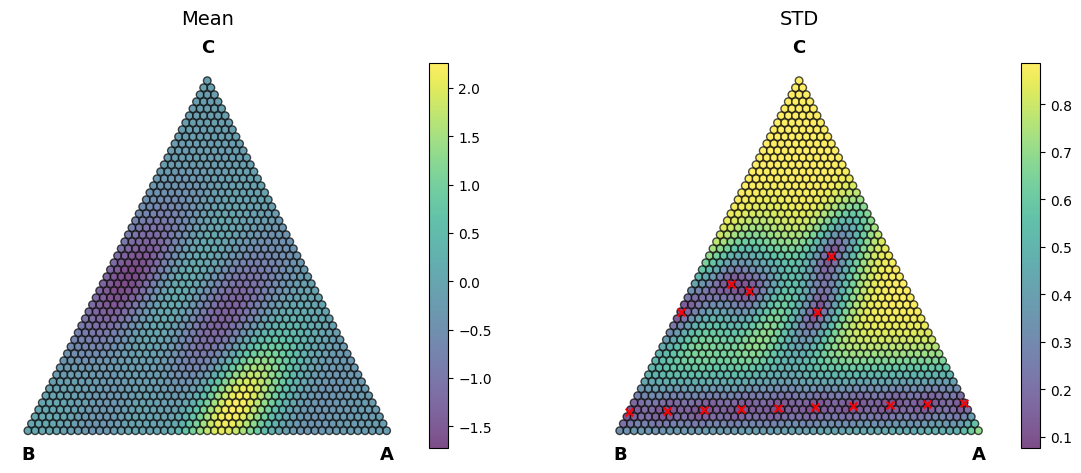

------ iter 1 ------


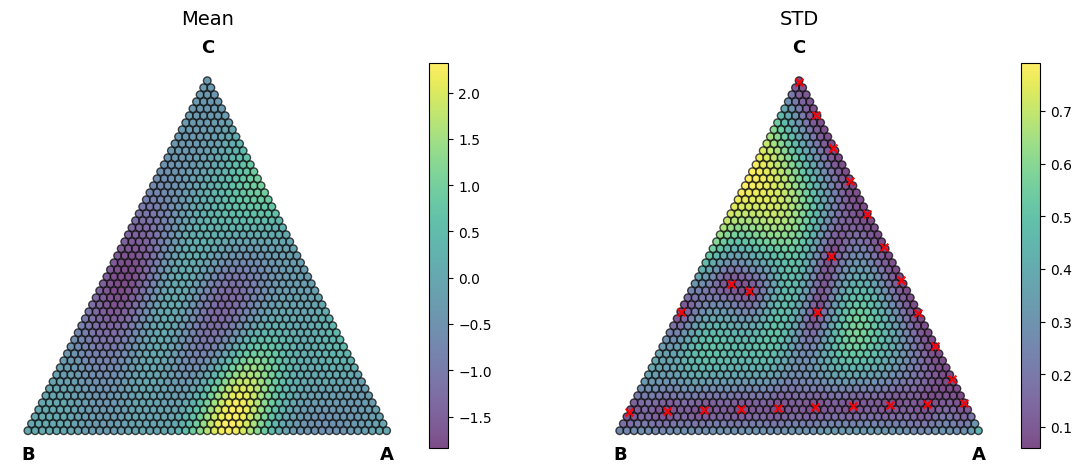

------ iter 2 ------


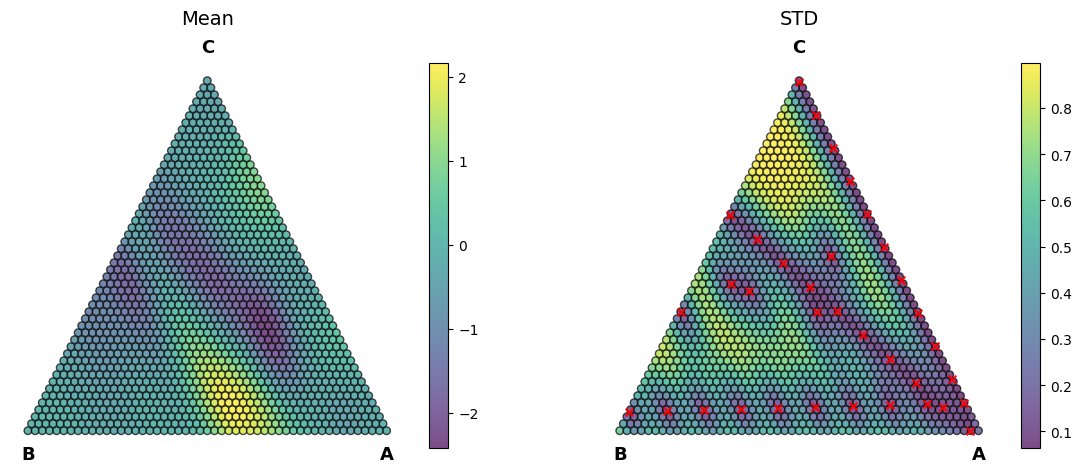

------ iter 3 ------


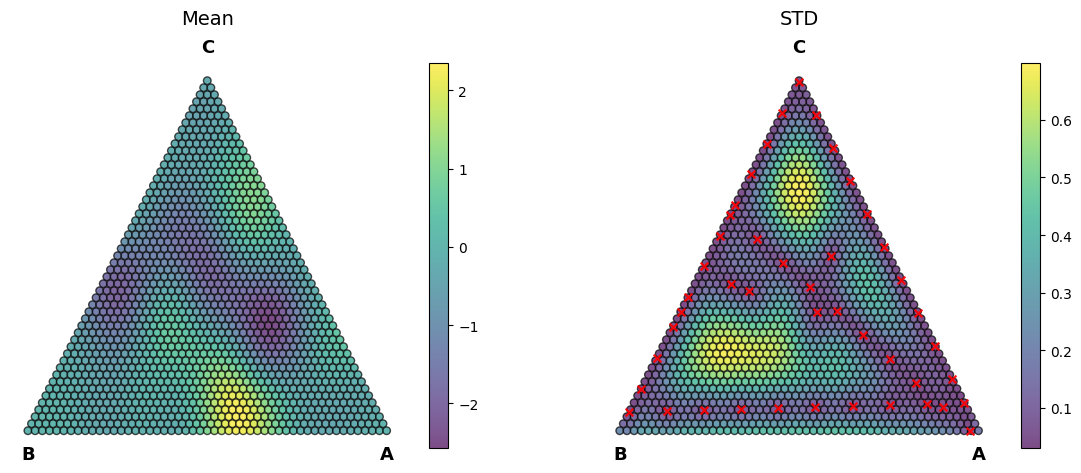

------ iter 4 ------


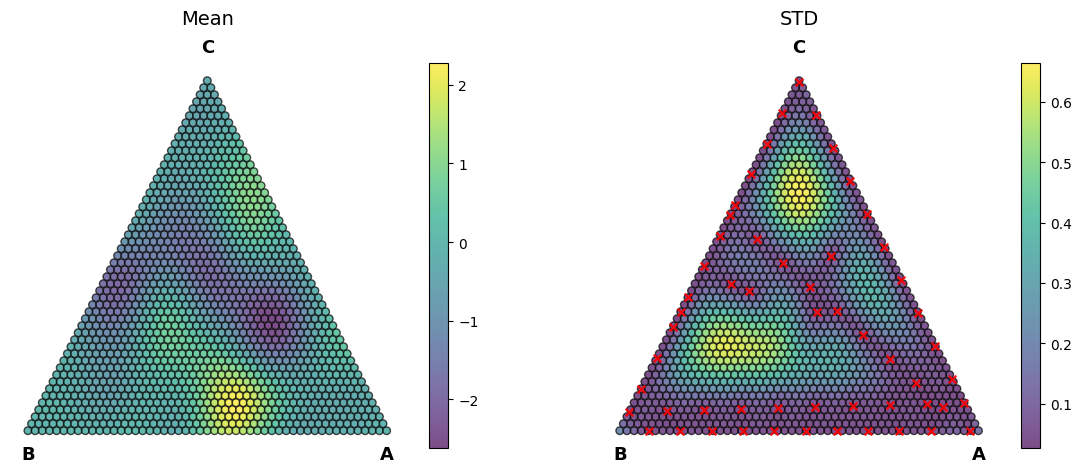

------ iter 5 ------


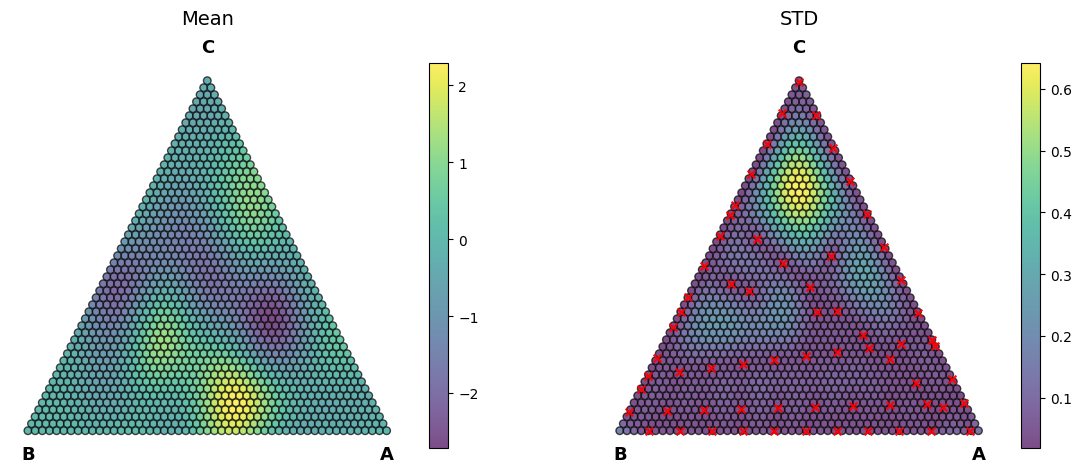

------ iter 6 ------


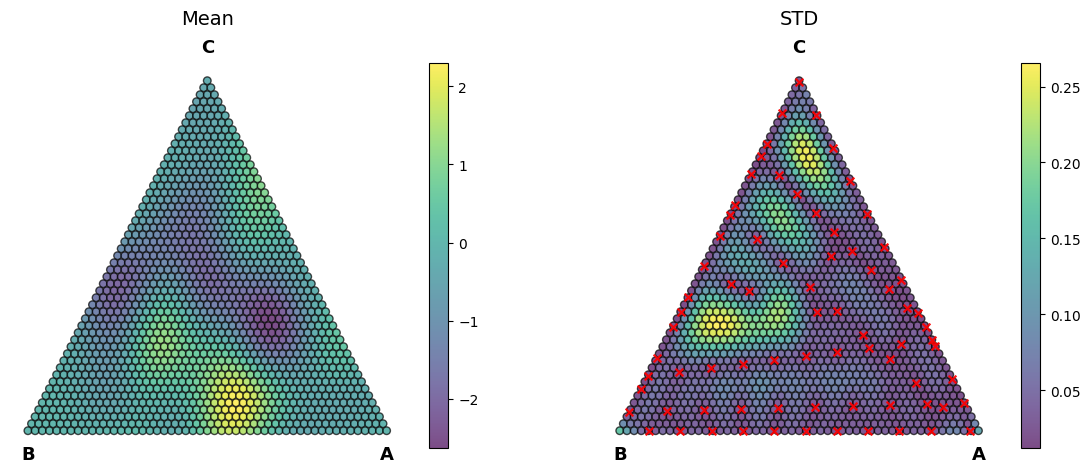

------ iter 7 ------


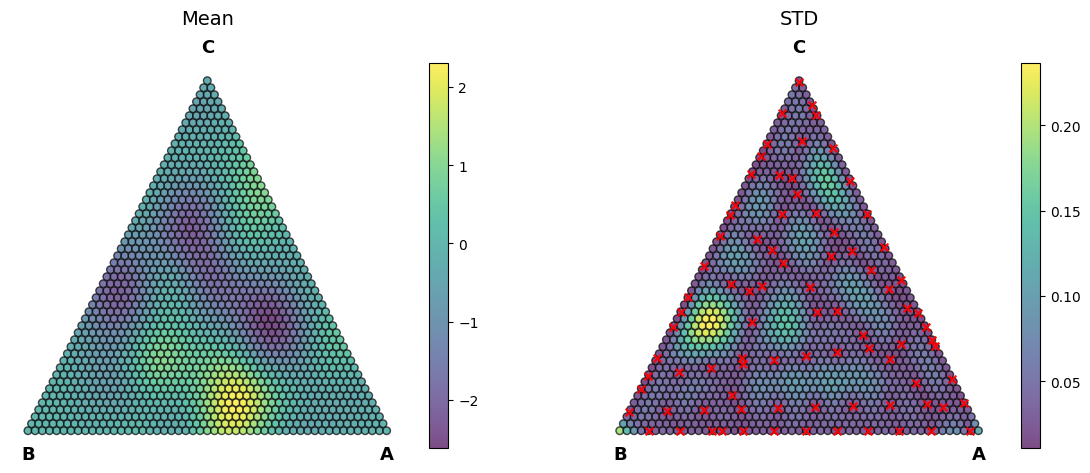

------ iter 8 ------


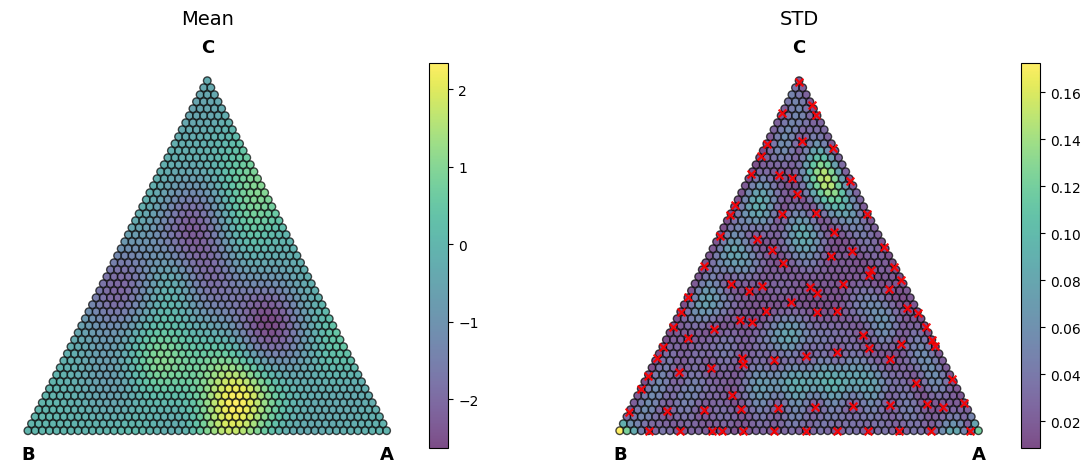

------ iter 9 ------


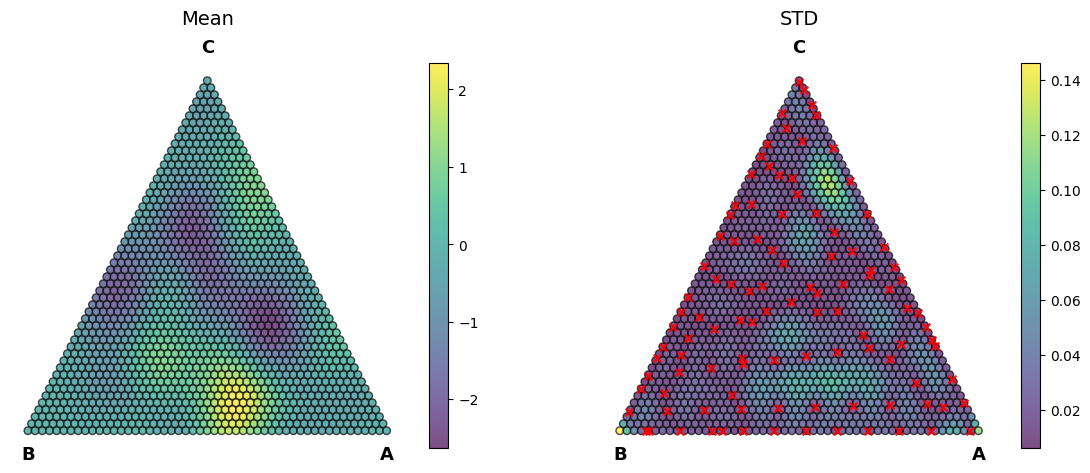

In [ ]:
n_iter = 10

#space
N = 3 #space dimensionality

#manifolds
dim_manifold = 1
n_manifolds = 500 #number of random manifolds at each iteration (substitution of the grid search)
n_points = 10 # number of points in 1d manifolds or number sampled on edge in the 2D manifold

alpha = 0 #0 - pure exproration, 1 - pure exploitation

res_dict = {}

#generate system
compositions = generate_composition_space(N=3, step=0.02)
coords = barycentric_to_cartesian(*compositions.T)
X_test = torch.tensor(compositions, dtype=torch.double)

#generate function
rng0 = np.random.default_rng(1)
f = make_random_property_function(N=3, K=106, sigma=0.1, noise_std=0.00, seed=1)
z = f(compositions)

#seed points
idx = np.random.choice(len(compositions), size=5, replace=False)

X_train = compositions[idx]
coords_train = coords[idx]
y_train = f(X_train)

gp, kl = make_gp_model(X_train, y_train)
posterior = gp.posterior(X_test)
mean = posterior.mean.detach().numpy().ravel()
std = posterior.variance.sqrt().detach().numpy().ravel()

res_dict['kl'] = np.array([kl,])
res_dict['std'] = np.array([std.mean(),])
res_dict['abs_error'] = np.array([(np.abs(mean - z)).mean(),])

#fig_mean_std = vis_mean_std(coords, mean, std, points=coords_train)

for iter in range(n_iter):
  print(f"------ iter {iter} ------")

  manifolds = generate_manifolds_array(
                  N,
                  manifold_dim=1,
                  n_manifolds=n_manifolds,
                  n_points_1d=n_points,
                  n_points_edge_2d=n_points,
                  boundary=True,
                  rng=None
              )

  scores, res = acquisition_for_manifolds(gp, manifolds, y_train.max(), alpha=0, xi=0.0)
  next_idx = np.argmax(scores)
  next_compositions = manifolds[next_idx]
  next_y =     f(next_compositions)

  X_train = np.vstack([X_train, next_compositions])
  y_train = np.append(y_train, next_y)
  coords_train = barycentric_to_cartesian(X_train[:,0],
                                          X_train[:,1],
                                          X_train[:,2])

  gp, kl = make_gp_model(X_train, y_train)
  posterior = gp.posterior(X_test)
  mean = posterior.mean.detach().numpy().ravel()
  std = posterior.variance.sqrt().detach().numpy().ravel()

  res_dict['kl']        = np.vstack([res_dict['kl'],  kl])
  res_dict['std']       = np.append(res_dict['std'], std.mean())
  res_dict['abs_error'] = np.append(res_dict['abs_error'], (np.abs(mean - z)).mean())

  fig_mean_std = vis_mean_std(coords, mean, std, points=coords_train)





/tmp/ipython-input-3783300907.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma')   # try: 'plasma', 'coolwarm', etc.


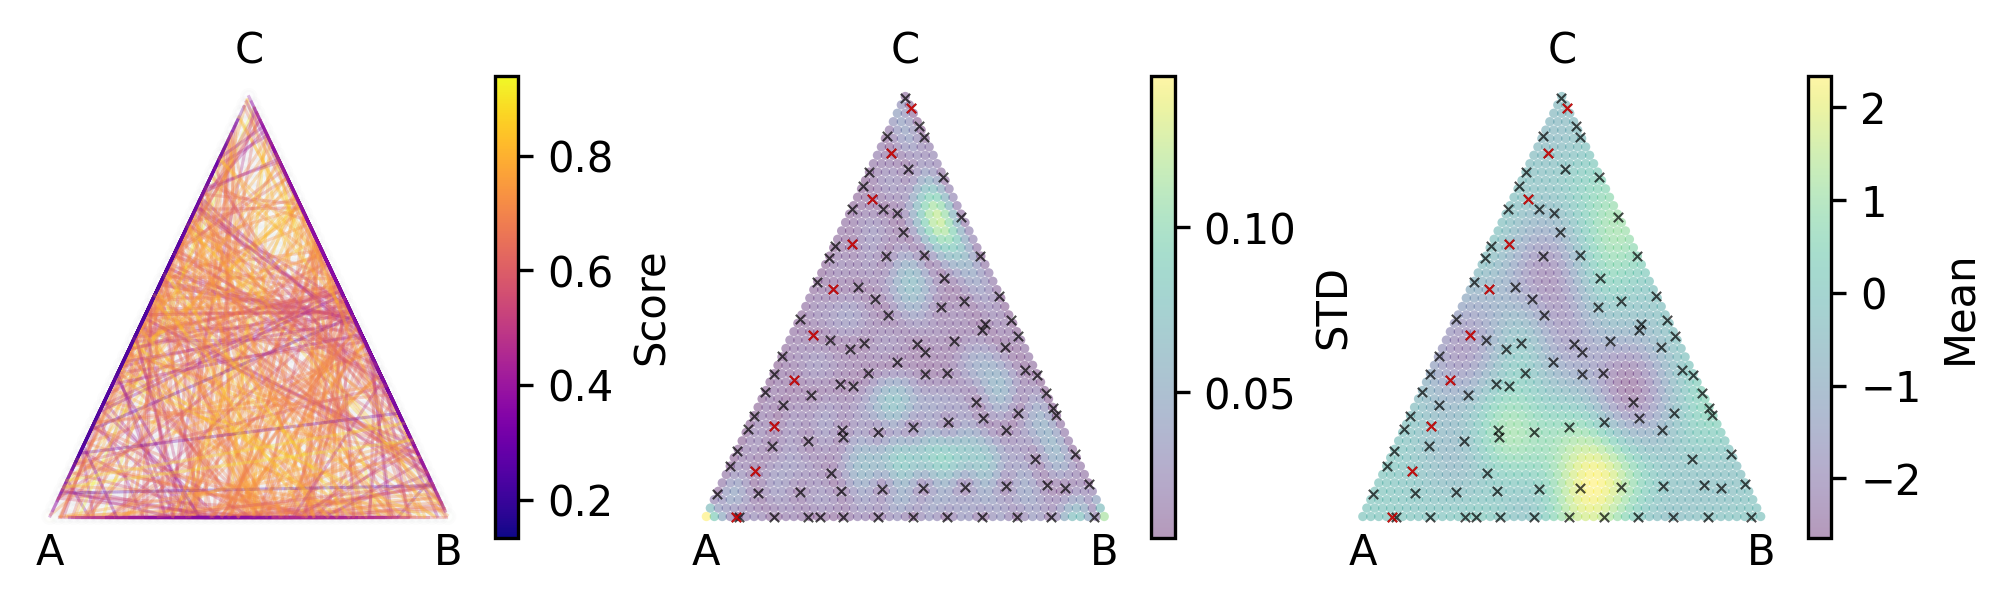

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

norm = mcolors.Normalize(vmin=scores.min(), vmax=scores.max())
cmap = cm.get_cmap('plasma')   # try: 'plasma', 'coolwarm', etc.
colors = cmap(norm(scores))



fig, ax = plt.subplots(1, 3, figsize=(8,2), dpi=300)

im0 = ax[0].scatter(coords[:, 0], coords[:, 1], c=std, s=10, edgecolor='k', alpha=.01)
#ax[0].set_title('Scores', y=1.08, fontsize=12)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='Score', ax=ax[0])
im0 = ax[1].scatter(coords[:, 0], coords[:, 1], c=std, s=5, edgecolor='k', linewidths=0, alpha=.4)
#ax[1].set_title('STD', y=1.08, fontsize=12)
plt.colorbar(im0, label='STD',)
im1 = ax[2].scatter(coords[:, 0], coords[:, 1], c=mean, s=5, edgecolor='k', alpha=.4, linewidths=0,)
#ax[2].set_title('Mean', y=1.08, fontsize=12)
plt.colorbar(im1, label='Mean')

mns = []
for i,m in enumerate(manifolds):
  c_m = barycentric_to_cartesian(*m.T)
  ax[0].plot(*c_m.T, '-', alpha=.3, color=colors[i], lw=.75)

ax[0].plot(mns, '-', alpha=.3, color='w', lw=.75)
m_n = barycentric_to_cartesian(*next_compositions.T)

#ax[0].plot(*m_n.T, '-', alpha=1, color='k', lw=.75)


for _ in ax[1:]:
  if coords_train is not None:
    _.scatter(coords_train[:, 0], coords_train[:, 1], marker='x', c='k', s=5, alpha=.7, linewidths=.5)
  _.scatter(coords_train[-10:, 0], coords_train[-10:, 1], marker='x', c='r', s=5, alpha=.7, linewidths=.5)

for _ in ax:

  _.text(0, -0.1, "A", ha='center', fontsize=10)#, fontweight='bold')
  _.text(1, -0.1, "B", ha='center', fontsize=10)#, fontweight='bold')
  _.text(0.5, np.sqrt(3)/2 + 0.07, "C", ha='center', fontsize=10)#, fontweight='bold')
  _.axis('off')

fig.savefig('fig1_intro.jpg', dpi=300, bbox_inches='tight')


## Comparing

In [ ]:
#@title manifold

def run_manifold_BO_experiment(
    N=3,
    n_iter=30,
    dim_manifold=1,
    n_manifolds=500,
    n_points=10,
    alpha=0.0,
    seed_function=1,
    seed_init=42,
    boundary=True,
    step=0.02
):
    """
    Run one full Bayesian optimization experiment using manifold sampling.

    Parameters
    ----------
    N : int
        Dimensionality of compositional space.
    n_iter : int
        Number of BO iterations.
    dim_manifold : int
        1 or 2 (line or patch manifolds).
    n_manifolds : int
        Number of random manifolds sampled per iteration.
    n_points : int
        Points per manifold (1D) or per edge (2D).
    alpha : float
        Weight for exploitation vs exploration (0 = pure exploration).
    seed_function : int
        Seed for creating the synthetic property landscape.
    seed_init : int
        Seed for selecting initial random training points.
    boundary : bool
        Whether manifolds lie on the simplex boundary.
    step : float
        Grid resolution for generating test compositions.

    Returns
    -------
    res_dict : dict
        Contains records of kernel lengthscales, mean std, absolute error.
    X_train, y_train : final GP training dataset.
    f : callable
        Synthetic property function used.
    """

    # -----------------------------------------------
    # 1. Setup and generate the evaluation grid
    # -----------------------------------------------
    compositions = generate_composition_space(N=N, step=step)
    #coords = barycentric_to_cartesian(*compositions.T)
    X_test = torch.tensor(compositions, dtype=torch.double)

    # -----------------------------------------------
    # 2. Make synthetic property function
    # -----------------------------------------------
    f = make_random_property_function(
        N=N,
        K=106,
        sigma=0.1,
        noise_std=0.01,
        seed=seed_function
    )
    z = f(compositions)

    # -----------------------------------------------
    # 3. Initial seed points
    # -----------------------------------------------
    rng = np.random.default_rng(seed_init)
    idx = rng.choice(len(compositions), size=5, replace=False)

    X_train = compositions[idx]
    #coords_train = coords[idx]
    y_train = f(X_train)

    gp, kl = make_gp_model(X_train, y_train)

    posterior = gp.posterior(X_test)
    mean = posterior.mean.detach().numpy().ravel()
    std = posterior.variance.sqrt().detach().numpy().ravel()

    # -----------------------------------------------
    # 4. Initialize results dictionary
    # -----------------------------------------------
    res_dict = {}
    res_dict['kl']        = np.array([kl])
    res_dict['std']       = np.array([std.mean()])
    res_dict['abs_error'] = np.array([(np.abs(mean - z)).mean()])

    # -----------------------------------------------
    # 5. BO loop over manifold batches
    # -----------------------------------------------
    for it in range(n_iter):
        print(f"------ iter {it} ------")

        manifolds = generate_manifolds_array(
            N=N,
            manifold_dim=dim_manifold,
            n_manifolds=n_manifolds,
            n_points_1d=n_points,
            n_points_edge_2d=n_points,
            boundary=boundary,
            rng=None,
        )

        # Acquisition over manifolds
        scores, res = acquisition_for_manifolds(
            gp,
            manifolds,
            f_best=y_train.max(),
            alpha=alpha,
            xi=0.0
        )

        next_idx = np.argmax(scores)
        next_compositions = manifolds[next_idx]
        next_y = f(next_compositions)

        # Add new batch to training data
        X_train = np.vstack([X_train, next_compositions])
        y_train = np.append(y_train, next_y)

        # coords_train = barycentric_to_cartesian(
        #     X_train[:,0],
        #     X_train[:,1],
        #     X_train[:,2]
        # )

        # Re-fit GP
        gp, kl = make_gp_model(X_train, y_train)
        posterior = gp.posterior(X_test)

        mean = posterior.mean.detach().numpy().ravel()
        std = posterior.variance.sqrt().detach().numpy().ravel()

        # Log metrics
        res_dict['kl']        = np.vstack([res_dict['kl'], kl])
        res_dict['std']       = np.append(res_dict['std'], std.mean())
        res_dict['abs_error'] = np.append(res_dict['abs_error'],
                                          (np.abs(mean - z)).mean())

    return res_dict, X_train, y_train, f


In [ ]:
#@title point-based BO

def run_point_BO_experiment(
    N=3,
    n_iter=30,
    n_init=5,
    seed_function=1,
    seed_init=42,
    step=0.02
):
    """
    Run standard point-by-point Bayesian Optimization using Maximum Uncertainty.

    Acquisition:
        a(x) = argmax_x Var[f(x)]  (largest posterior std dev)

    Parameters
    ----------
    N : int
        Dimensionality of the compositional space.
    n_iter : int
        Number of BO iterations.
    n_init : int
        Number of initial random points.
    seed_function : int
        Seed for the random synthetic landscape.
    seed_init : int
        Seed for initial points.
    step : float
        Grid resolution for discretizing the simplex.

    Returns
    -------
    res_dict : dict
        log of kernel lengthscales, uncertainty curve, abs error curve
    X_train, y_train : final training dataset
    f : callable
        random property function used
    """

    # -------------------------------------------------
    # 1. Generate compositional grid (evaluation space)
    # -------------------------------------------------
    compositions = generate_composition_space(N=N, step=step)
    #coords = barycentric_to_cartesian(*compositions.T)
    X_test = torch.tensor(compositions, dtype=torch.double)

    # -------------------------------------------------
    # 2. Create synthetic property landscape
    # -------------------------------------------------
    f = make_random_property_function(
        N=N,
        K=106,
        sigma=0.1,
        noise_std=0.01,
        seed=seed_function
    )
    z = f(compositions)

    # -------------------------------------------------
    # 3. Pick initial seed points
    # -------------------------------------------------
    rng = np.random.default_rng(seed_init)
    idx = rng.choice(len(compositions), size=n_init, replace=False)

    X_train = compositions[idx]
    y_train = f(X_train)

    # -------------------------------------------------
    # 4. Fit GP
    # -------------------------------------------------
    gp, kl = make_gp_model(X_train, y_train)

    posterior = gp.posterior(X_test)
    mean = posterior.mean.detach().numpy().ravel()
    std  = posterior.variance.sqrt().detach().numpy().ravel()

    # -------------------------------------------------
    # 5. Initialize log dictionary
    # -------------------------------------------------
    res_dict = {}
    res_dict['kl']        = np.array([kl])
    res_dict['std']       = np.array([std.mean()])
    res_dict['abs_error'] = np.array([(np.abs(mean - z)).mean()])

    # -------------------------------------------------
    # 6. Bayesian Optimization Loop (point-by-point)
    # -------------------------------------------------
    for it in range(n_iter):
        print(f"---- iter {it} ----")

        # ---------------------------------------------
        # 6.1 Acquisition: Maximum Uncertainty
        # ---------------------------------------------
        # We choose the point with largest posterior variance
        next_idx = np.argmax(std)
        next_x = compositions[next_idx]
        next_y = f(next_x.reshape(1, -1))

        # ---------------------------------------------
        # 6.2 Update training data
        # ---------------------------------------------
        X_train = np.vstack([X_train, next_x])
        y_train = np.append(y_train, next_y)

        # ---------------------------------------------
        # 6.3 Refit GP
        # ---------------------------------------------
        gp, kl = make_gp_model(X_train, y_train)
        posterior = gp.posterior(X_test)

        mean = posterior.mean.detach().numpy().ravel()
        std  = posterior.variance.sqrt().detach().numpy().ravel()

        # Log metrics
        res_dict['kl']        = np.vstack([res_dict['kl'], kl])
        res_dict['std']       = np.append(res_dict['std'], std.mean())
        res_dict['abs_error'] = np.append(res_dict['abs_error'],
                                          (np.abs(mean - z)).mean())

    return res_dict, X_train, y_train, f


In [ ]:
n_runs = 50

N = 4

n_iter = 16
n_points = 6
n_manifolds=500
dim_manifolds = 2
alpha = 0.

all_runs = []
all_runs_pt = []
for rep in range(n_runs):
    print(f"=== RUN {rep} ===")
    res, Xf, yf, ffun = run_manifold_BO_experiment(
        N=N,
        n_iter=n_iter,
        dim_manifold=dim_manifolds,
        n_manifolds=n_manifolds,
        n_points=n_points,
        alpha=alpha,
        seed_function=rep,   # different landscape each time
        seed_init=rep + 100  # different init points each time
    )
    all_runs.append(res)

    res_pt, X_pt, y_pt, f_pt = run_point_BO_experiment(
        N=N,
        n_iter=n_iter*21,#n_iter*n_points,
        seed_function=rep,
        seed_init=rep + 100
    )
    all_runs_pt.append(res_pt)



Streaming output truncated to the last 5000 lines.
---- iter 278 ----
---- iter 279 ----
---- iter 280 ----
---- iter 281 ----
---- iter 282 ----
---- iter 283 ----
---- iter 284 ----
---- iter 285 ----
---- iter 286 ----
---- iter 287 ----
---- iter 288 ----
---- iter 289 ----
---- iter 290 ----
---- iter 291 ----
---- iter 292 ----
---- iter 293 ----
---- iter 294 ----
---- iter 295 ----
---- iter 296 ----
---- iter 297 ----
---- iter 298 ----
---- iter 299 ----
---- iter 300 ----
---- iter 301 ----
---- iter 302 ----
---- iter 303 ----
---- iter 304 ----
---- iter 305 ----
---- iter 306 ----
---- iter 307 ----
---- iter 308 ----
---- iter 309 ----
---- iter 310 ----
---- iter 311 ----
---- iter 312 ----
---- iter 313 ----
---- iter 314 ----
---- iter 315 ----
---- iter 316 ----
---- iter 317 ----
---- iter 318 ----
---- iter 319 ----
---- iter 320 ----
---- iter 321 ----
---- iter 322 ----
---- iter 323 ----
---- iter 324 ----
---- iter 325 ----
---- iter 326 ----
---- iter 327 ----

In [ ]:
import h5py
import numpy as np
import json

def save_dict_to_hdf5(file_path, data_dict):
    with h5py.File(file_path, 'w') as f:
        _recursively_save(f, data_dict)

def _recursively_save(group, data):
    if isinstance(data, dict):
        for key, value in data.items():
            subgroup = group.create_group(str(key))
            _recursively_save(subgroup, value)

    elif isinstance(data, list):
        # Turn list into group with numerical keys
        for i, item in enumerate(data):
            subgroup = group.create_group(str(i))
            _recursively_save(subgroup, item)

    elif isinstance(data, np.ndarray):
        if data.dtype == object:
            # convert each element to string (json)
            data_as_str = np.array([json.dumps(x) for x in data], dtype='S256')
            group.create_dataset('value', data=data_as_str)
        else:
            group.create_dataset('value', data=data)

    elif isinstance(data, (int, float, np.int_, np.float_)):
        group.create_dataset('value', data=data)

    elif data is None:
        group.attrs['value'] = 'None'

    else:
        # Fallback: convert unknown object to JSON string
        group.create_dataset('value', data=json.dumps(data))


def load_hdf5_to_dict(file_path):
    with h5py.File(file_path, "r") as f:
        return _load_item(f)



def _load_item(obj):
    """
    Load any HDF5 object (Group or Dataset) and reconstruct Python object.
    """
    # ---------------------------------------------------------
    # CASE 1 — HDF5 GROUP  (recursive dict or list)
    # ---------------------------------------------------------
    if isinstance(obj, h5py.Group):
        keys = list(obj.keys())

        # Empty group → return None or empty dict
        if len(keys) == 0 and "value" not in obj.attrs:
            return {}

        # Detect list: all keys are integers
        if all(k.isdigit() for k in keys):
            lst = []
            for k in sorted(keys, key=lambda x: int(x)):
                lst.append(_load_item(obj[k]))
            return lst

        # Regular dictionary
        out = {}
        for k in keys:
            out[k] = _load_item(obj[k])

        # Special case: group representing None
        if "value" in obj.attrs and obj.attrs["value"] == "None":
            return None

        return out

    # ---------------------------------------------------------
    # CASE 2 — HDF5 DATASET  (arrays / scalars / strings)
    # ---------------------------------------------------------
    elif isinstance(obj, h5py.Dataset):
        data = obj[()]

        # Scalar
        if np.isscalar(data):
            return data

        # Byte strings → JSON or text
        if isinstance(data, (bytes, np.bytes_)):
            try:
                return json.loads(data.decode())
            except:
                return data.decode()

        # Array of byte strings
        if data.dtype.kind == "S":
            try:
                return [json.loads(x.decode()) for x in data]
            except:
                return [x.decode() for x in data]

        # Normal numpy array
        return data

    # ---------------------------------------------------------
    # CASE 3 — Attributes marking None
    # ---------------------------------------------------------
    else:
        raise ValueError("Unknown HDF5 object type:", obj)


def get_arr(runs, key):
    """
    Extract numpy array from runs[key], automatically handling nested {'value': array}.
    """
    val = runs[key]
    if isinstance(val, dict) and "value" in val:
        return np.asarray(val["value"])
    return np.asarray(val)



In [ ]:
full_res = {
    'all_runs': list(all_runs),
    'all_runs_pt': list(all_runs_pt),
    'n_runs': np.array(n_runs),
    'n_points': np.array(n_points),
    'n_manifolds': np.array(n_manifolds),
    'dim_manifolds': np.array(dim_manifolds),
    'alpha': np.array(alpha)
}

In [ ]:
save_dict_to_hdf5('exp11_N4_2d.h5', full_res)

## result treatment

In [ ]:
full_res = load_hdf5_to_dict('/content/exp10_N4_1d.h5')

In [ ]:
all_runs = full_res['all_runs']
all_runs_pt = full_res['all_runs_pt']
n_points = int(full_res['n_points']['value'])

In [ ]:
#time models

t_s = 1
ratio_m_s = np.linspace(0.3, 1, 25)
t_m = n_points*t_s*ratio_m_s#21*t_s*ratio_m_s#

In [ ]:
# Extract arrays from manifold BO runs
std       = np.array([get_arr(r, "std")       for r in all_runs])
abs_error = np.array([get_arr(r, "abs_error") for r in all_runs])

# Extract arrays from point BO runs
std_pt       = np.array([get_arr(r, "std")       for r in all_runs_pt])
abs_error_pt = np.array([get_arr(r, "abs_error") for r in all_runs_pt])

# Averages across multiple runs
mean_std_pt       = std_pt.mean(axis=0)
mean_ae_pt        = abs_error_pt.mean(axis=0)

mean_std_man      = std.mean(axis=0)
mean_ae_man       = abs_error.mean(axis=0)


iter_manifolds = np.arange(std.shape[1])
iter_single = np.arange(std_pt.shape[1])

In [ ]:
ratio_m_s[14]

np.float64(0.7083333333333333)

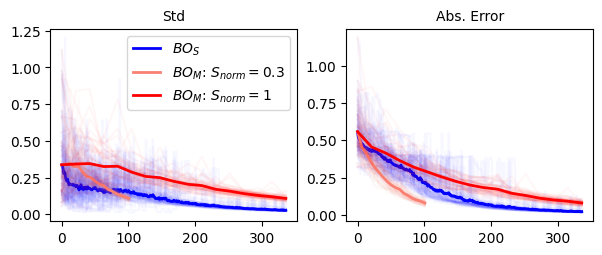

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7,2.5))

ax[0].plot(std_pt.T, c='b', alpha=0.03)
ax[0].plot(std_pt.mean(0), c='b', lw=2, label='$BO_S$')

ax[0].plot(iter_manifolds*t_m[0], std.T, c='salmon', alpha=0.03)
ax[0].plot(iter_manifolds*t_m[0], std.mean(0), c='salmon', lw=2, label='$BO_M$: $S_{norm}=0.3$')

ax[0].plot(iter_manifolds*t_m[-1], std.T, c='r', alpha=0.03)
ax[0].plot(iter_manifolds*t_m[-1], std.mean(0), c='r', lw=2, label='$BO_M$: $S_{norm}=1$')


ax[1].plot(abs_error_pt.T, c='b', alpha=0.03)
ax[1].plot(abs_error_pt.mean(0), c='b', lw=2)

ax[1].plot(iter_manifolds*t_m[0], abs_error.T, c='salmon', alpha=0.03)
ax[1].plot(iter_manifolds*t_m[0], abs_error.mean(0), c='salmon', lw=2)

ax[1].plot(iter_manifolds*t_m[-1], abs_error.T, c='r', alpha=0.03)
ax[1].plot(iter_manifolds*t_m[-1], abs_error.mean(0), c='r', lw=2)

ax[0].set_title('Std', fontsize=10)
ax[1].set_title('Abs. Error', fontsize=10)

ax[0].legend()

In [ ]:
from scipy.interpolate import interp1d

times_manifold = iter_manifolds*t_m.reshape(-1,1)
times_single   = iter_single*t_s

f_std_pt = interp1d(times_single, mean_std_pt, kind='cubic')
f_ae_pt  = interp1d(times_single, mean_ae_pt , kind='cubic')

t_min ,t_max = times_manifold[0].min(), times_manifold[0].max()

std_pt_ = f_std_pt(np.linspace(t_min, t_max, 200))
ae_pt_  = f_ae_pt(np.linspace(t_min, t_max, 200))

bool_std = []
bool_ae = []

bool_std1 = []
bool_ae1 = []

for tm in times_manifold:
  f_std = interp1d(tm, mean_std_man, kind='cubic')
  f_ae = interp1d(tm, mean_ae_man, kind='cubic')

  std_ = f_std(np.linspace(t_min, t_max, 200))
  ae_  =  f_ae(np.linspace(t_min, t_max, 200))

  bool_std_ = std_pt_ - std_
  bool_std1_ = bool_std_ > 0
  bool_std_[abs(bool_std_) <0.02] = 0
  bool_ae_ = ae_pt_ - ae_
  bool_ae1_ = bool_ae_ > 0
  bool_ae_[abs(bool_ae_) <0.02] = 0



  bool_std.append(bool_std_)
  bool_ae.append(bool_ae_)
  bool_std1.append(bool_std1_)
  bool_ae1.append(bool_ae1_)

bool_std = np.array(bool_std)
bool_ae  = np.array(bool_ae)

bool_std1 = np.array(bool_std1)
bool_ae1  = np.array(bool_ae1)


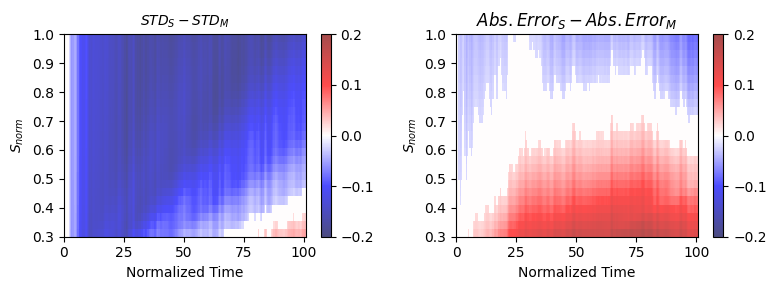

In [ ]:
contours = measure.find_contours(bool_std1.astype(float), 0.5)

fig, ax = plt.subplots(1, 2, figsize=(8,3))

im = ax[0].imshow(
    bool_std,
    cmap="seismic",
    extent=[t_min, t_max, ratio_m_s[0], ratio_m_s[-1]],
    aspect="auto",
    origin="lower",
    interpolation='nearest',
    vmin=-0.2,
    vmax=0.2,
    alpha=0.7
)

#ax[0].plot(contours[1].T[1], contours[1].T[0])

plt.colorbar(im)
ax[0].set_title("$STD_{S}-STD_{M}$", fontsize=10)

im1 = ax[1].imshow(
    bool_ae,
    cmap="seismic",
    extent=[t_min, t_max, ratio_m_s[0], ratio_m_s[-1]],
    aspect="auto",
    origin="lower",
    interpolation='nearest',
    vmin=-0.2,
    vmax=0.2,
    alpha=0.7
)
plt.colorbar(im1)
ax[1].set_title("$Abs.Error_{S}-Abs.Error_{M}$")

for _ in ax:
  _.set_ylabel("$S_{norm}$", fontsize=10)
  _.set_xlabel("Normalized Time", fontsize=10)

plt.tight_layout()

fig.savefig('diag_1d.jpg', dpi=300, bbox_inches='tight')

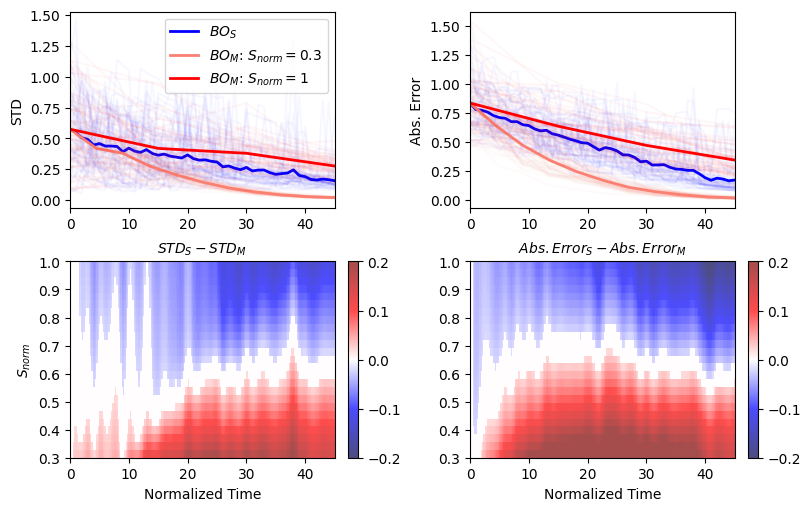

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5), constrained_layout=True)

# =======================
# (a) STD vs time
# =======================
axs[0, 0].plot(std_pt.T, c='b', alpha=0.03)
axs[0, 0].plot(std_pt.mean(0), c='b', lw=2, label='$BO_S$')

axs[0, 0].plot(iter_manifolds*t_m[0], std.T, c='salmon', alpha=0.03)
axs[0, 0].plot(iter_manifolds*t_m[0], std.mean(0), c='salmon', lw=2, label='$BO_M$: $S_{norm}=0.3$')

axs[0, 0].plot(iter_manifolds*t_m[-1], std.T, c='r', alpha=0.03)
axs[0, 0].plot(iter_manifolds*t_m[-1], std.mean(0), c='r', lw=2, label='$BO_M$: $S_{norm}=1$')

#axs[0, 0].set_title('STD', fontsize=10)
axs[0, 0].legend()
axs[0, 0].set_xlim(t_min, t_max)


# =======================
# (b) Abs. Error vs time
# =======================
axs[0, 1].plot(abs_error_pt.T, c='b', alpha=0.03)
axs[0, 1].plot(abs_error_pt.mean(0), c='b', lw=2)

axs[0,1].plot(iter_manifolds*t_m[0], abs_error.T, c='salmon', alpha=0.03)
axs[0,1].plot(iter_manifolds*t_m[0], abs_error.mean(0), c='salmon', lw=2)

axs[0,1].plot(iter_manifolds*t_m[-1], abs_error.T, c='r', alpha=0.03)
axs[0,1].plot(iter_manifolds*t_m[-1], abs_error.mean(0), c='r', lw=2)

#axs[0, 1].set_title('Abs. Error', fontsize=10)
axs[0, 1].set_xlim(t_min, t_max)


# =======================
# (c) STD difference map
# =======================
im0 = axs[1, 0].imshow(
    bool_std,
    cmap="seismic",
    extent=[t_min, t_max, ratio_m_s[0], ratio_m_s[-1]],
    aspect="auto",
    origin="lower",
    interpolation='nearest',
    vmin=-0.2,
    vmax=0.2,
    alpha=0.7
)

axs[1, 0].set_title(r"$STD_S - STD_M$", fontsize=10)
fig.colorbar(im0, ax=axs[1, 0])


# =======================
# (d) Abs. Error difference map
# =======================
im1 = axs[1, 1].imshow(
    bool_ae,
    cmap="seismic",
    extent=[t_min, t_max, ratio_m_s[0], ratio_m_s[-1]],
    aspect="auto",
    origin="lower",
    interpolation='nearest',
    vmin=-0.2,
    vmax=0.2,
    alpha=0.7
)

axs[1, 1].set_title(r"$Abs.Error_S - Abs.Error_M$", fontsize=10)
fig.colorbar(im1, ax=axs[1, 1])


# =======================
# Axis labels
# =======================
for ax in axs[1, :]:
    ax.set_xlabel("Normalized Time", fontsize=10)


axs[1, 0].set_ylabel(r"$S_{norm}$", fontsize=10)
axs[0, 0].set_ylabel(r"STD", fontsize=10)
axs[0, 1].set_ylabel(r"Abs. Error", fontsize=10)

fig.savefig('fig2.jpg', dpi=300, bbox_inches='tight')

# Data Treatment

In [ ]:
!gdown https://drive.google.com/file/d/1euWsXKiH0Wy1B4NbsdEeQw3h5NdqMYS3/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1euWsXKiH0Wy1B4NbsdEeQw3h5NdqMYS3
To: /content/mf_bo_1.zip
100% 4.88M/4.88M [00:00<00:00, 19.6MB/s]


In [ ]:
!unzip mf_bo_1.zip

Archive:  mf_bo_1.zip
   creating: mf_bo_1/
  inflating: mf_bo_1/exp3_N3.h5      
  inflating: __MACOSX/mf_bo_1/._exp3_N3.h5  
  inflating: mf_bo_1/exp1_N3.h5      
  inflating: __MACOSX/mf_bo_1/._exp1_N3.h5  
  inflating: mf_bo_1/exp7_N4_2d.h5   
  inflating: __MACOSX/mf_bo_1/._exp7_N4_2d.h5  
  inflating: mf_bo_1/exp2_N3.h5      
  inflating: __MACOSX/mf_bo_1/._exp2_N3.h5  
  inflating: mf_bo_1/exp8_N4_2d.h5   
  inflating: __MACOSX/mf_bo_1/._exp8_N4_2d.h5  
  inflating: mf_bo_1/exp4_N4.h5      
  inflating: __MACOSX/mf_bo_1/._exp4_N4.h5  
  inflating: mf_bo_1/exp6_N4.h5      
  inflating: __MACOSX/mf_bo_1/._exp6_N4.h5  
  inflating: mf_bo_1/exp3_N4.h5      
  inflating: __MACOSX/mf_bo_1/._exp3_N4.h5  
  inflating: mf_bo_1/exp5_N4.h5      
  inflating: __MACOSX/mf_bo_1/._exp5_N4.h5  


In [ ]:
folder = f'/content/mf_bo_1/'

### 3D

In [ ]:
from matplotlib.colors import ListedColormap, BoundaryNorm

In [ ]:
colors = ["w", "lightblue", "deepskyblue", "b",]
          #"#ff7f00", "#ffff33"]

cmap = ListedColormap(colors)
bounds = np.arange(len(colors)+1) - 0.5
norm = BoundaryNorm(bounds, cmap.N)

In [ ]:
p5_3d = load_hdf5_to_dict(folder + 'exp1_N3.h5')
p10_3d = load_hdf5_to_dict(folder + 'exp2_N3.h5')
p15_3d = load_hdf5_to_dict(folder + 'exp3_N3.h5')

In [ ]:
import numpy as np
from scipy.interpolate import interp1d

def compute_bo_comparison(full_res, tol=0.02, n_interp=200, ratio=True):
    """
    Computes boolean comparison maps (std and abs_error)
    for manifold BO vs point BO and extracts boundary curves.

    Parameters
    ----------
    full_res : dict
        Contains all_runs, all_runs_pt, n_points, etc.
    tol : float
        Threshold for setting small differences to zero.
    n_interp : int
        Number of interpolation points for resampling.

    Returns
    -------
    results : dict
        Contains:
            bool_std, bool_ae           : signed differences
            bool_std1, bool_ae1         : boolean maps (>0)
            times_manifold, times_single
            t_min, t_max
            curve_std, curve_ae         : boundary curves
    """

    def get_arr(run_dict, key):
        return run_dict[key]["value"]

    # -------------------------
    # Extract data
    # -------------------------
    all_runs    = full_res['all_runs']
    all_runs_pt = full_res['all_runs_pt']
    n_points    = int(full_res['n_points']['value'])

    t_s = 1
    if ratio == True:
      ratio_m_s = np.linspace(0.3, 1, 100)
      beta = None
      dt = None
    elif ratio == 'beta':
      dt = None
      beta = np.linspace(0.3, 1, 100)
      ratio_m_s = factor(1., beta)/n_points
    elif ratio == 'dt':
      beta = None
      dt = np.linspace(0.1, 5, 100)
      ratio_m_s = factor(dt, 1.)/n_points
    t_m = n_points * t_s * ratio_m_s

    # Arrays from manifold BO
    std       = np.array([get_arr(r, "std")       for r in all_runs])
    abs_error = np.array([get_arr(r, "abs_error") for r in all_runs])

    # Arrays from point BO
    std_pt       = np.array([get_arr(r, "std")       for r in all_runs_pt])
    abs_error_pt = np.array([get_arr(r, "abs_error") for r in all_runs_pt])

    # Means
    mean_std_pt  = std_pt.mean(axis=0)
    mean_ae_pt   = abs_error_pt.mean(axis=0)
    mean_std_man = std.mean(axis=0)
    mean_ae_man  = abs_error.mean(axis=0)

    iter_manifolds = np.arange(std.shape[1])
    iter_single    = np.arange(std_pt.shape[1])

    times_manifold = iter_manifolds * t_m.reshape(-1, 1)
    times_single   = iter_single * t_s

    # Interpolate point BO
    f_std_pt = interp1d(times_single, mean_std_pt, kind='cubic')
    f_ae_pt  = interp1d(times_single, mean_ae_pt , kind='cubic')

    t_min, t_max = times_manifold[0].min(), times_manifold[0].max()
    t_grid = np.linspace(t_min, t_max, n_interp)

    std_pt_ = f_std_pt(t_grid)
    ae_pt_  = f_ae_pt(t_grid)

    bool_std  = []
    bool_ae   = []
    bool_std1 = []
    bool_ae1  = []

    # -------------------------
    # Compute boolean maps
    # -------------------------
    for tm in times_manifold:

        f_std = interp1d(tm, mean_std_man, kind='cubic')
        f_ae  = interp1d(tm, mean_ae_man , kind='cubic')

        std_ = f_std(t_grid)
        ae_  = f_ae(t_grid)

        diff_std = std_pt_ - std_
        diff_ae  = ae_pt_  - ae_

        # threshold small differences
        diff_std[np.abs(diff_std) < tol] = 0
        diff_ae [np.abs(diff_ae ) < tol] = 0

        diff_std_bool = diff_std > 0
        diff_ae_bool  = diff_ae  > 0

        bool_std.append(diff_std)
        bool_ae.append(diff_ae)
        bool_std1.append(diff_std_bool)
        bool_ae1.append(diff_ae_bool)

    bool_std  = np.array(bool_std)
    bool_ae   = np.array(bool_ae)
    bool_std1 = np.array(bool_std1)
    bool_ae1  = np.array(bool_ae1)

    # -------------------------
    # Boundary extraction helper
    # -------------------------
    def extract_curve(bool2d):
        """
        Returns x,y arrays of boundary pixels between True/False.
        """
        A = bool2d.astype(int)

        gy = np.abs(np.diff(A, axis=0))
        gx = np.abs(np.diff(A, axis=1))

        y1, x1 = np.where(gy == 1)
        y2, x2 = np.where(gx == 1)

        X = np.concatenate([x1, x2])
        Y = np.concatenate([y1, y2])

        return X, Y

    # curves for the mean maps
    curve_std = extract_curve(bool_std1)
    curve_ae  = extract_curve(bool_ae1)

    return dict(
        bool_std=bool_std,
        bool_ae=bool_ae,
        bool_std1=bool_std1,
        bool_ae1=bool_ae1,
        times_manifold=times_manifold,
        times_single=times_single,
        t_min=t_min,
        t_max=t_max,
        curve_std=curve_std,
        curve_ae=curve_ae,
        ratio_m_s = ratio_m_s,
        beta = beta,
        dt = dt,
    )


In [ ]:
p5_res_3d = compute_bo_comparison(p5_3d, tol=0.02, n_interp=200)
p10_res_3d = compute_bo_comparison(p10_3d, tol=0.02, n_interp=200)
p15_res_3d = compute_bo_comparison(p15_3d, tol=0.02, n_interp=200)

p5_res1_3d = compute_bo_comparison(p5_3d, tol=0.02, n_interp=200, ratio='beta')
p10_res1_3d = compute_bo_comparison(p10_3d, tol=0.02, n_interp=200, ratio='beta')
p15_res1_3d = compute_bo_comparison(p15_3d, tol=0.02, n_interp=200, ratio='beta')

p5_res2_3d = compute_bo_comparison(p5_3d, tol=0.02, n_interp=200, ratio='dt')
p10_res2_3d = compute_bo_comparison(p10_3d, tol=0.02, n_interp=200, ratio='dt')
p15_res2_3d = compute_bo_comparison(p15_3d, tol=0.02, n_interp=200, ratio='dt')

In [ ]:
stack = np.stack([np.zeros(p5_res_3d['bool_std1'].shape), p5_res_3d['bool_std1'], p10_res_3d['bool_std1'], p15_res_3d['bool_std1']], axis=0)
max_map = np.max(stack, axis=0)
winner_std_3d = np.argmax(stack, axis=0)

stack = np.stack([np.zeros(p5_res_3d['bool_ae'].shape), p5_res_3d['bool_ae'], p10_res_3d['bool_ae'], p15_res_3d['bool_ae']], axis=0)
max_map = np.max(stack, axis=0)
winner_ae_3d = np.argmax(stack, axis=0)

[Text(1, 0, '1'), Text(1, 1, '5'), Text(1, 2, '10'), Text(1, 3, '15')]

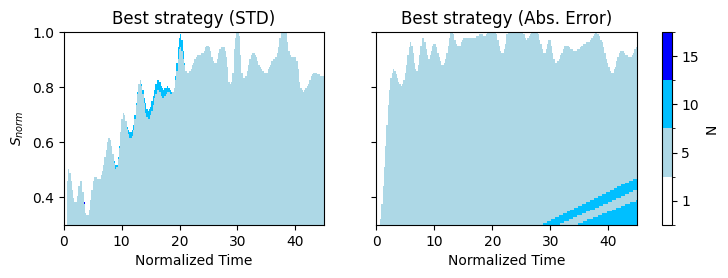

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2.5), sharex=True, sharey=True)

# ---------- subplot (a): min STD ----------
map_std = (
    p5_res_3d['bool_std1'].astype(int)
  + p10_res_3d['bool_std1'].astype(int)
  + p15_res_3d['bool_std1'].astype(int)
)

im0 = axs[0].imshow(
    winner_std_3d,
    origin='lower',
    extent=(p5_res_3d['t_min'], p5_res_3d['t_max'],
            p5_res_3d['ratio_m_s'][0], p5_res_3d['ratio_m_s'][-1]),
    aspect='auto',
    interpolation='nearest',
    cmap=cmap,
    norm=norm,
)

axs[0].set_title('Best strategy (STD)')
axs[0].set_ylabel(r"$S_{norm}$", fontsize=10)
axs[0].set_xlabel("Normalized Time", fontsize=10)


# ---------- subplot (b): min Error ----------
map_err = (
    p5_res_3d['bool_ae1'].astype(int)
  + p10_res_3d['bool_ae1'].astype(int)
  + p15_res_3d['bool_ae1'].astype(int)
)

im1 = axs[1].imshow(
    winner_ae_3d,
    origin='lower',
    extent=(p5_res_3d['t_min'], p5_res_3d['t_max'],
            p5_res_3d['ratio_m_s'][0], p5_res_3d['ratio_m_s'][-1]),
    aspect='auto',
    interpolation='nearest',
    cmap=cmap,
    norm=norm,
)

axs[1].set_title('Best strategy (Abs. Error)')
axs[1].set_xlabel("Normalized Time", fontsize=10)


# ---------- shared colorbar ----------
cbar = fig.colorbar(
    im1,
    ax=axs,
    ticks=np.arange(len(colors)),
    fraction=0.035,
    pad=0.04,
    label='N'
)

cbar.ax.set_yticklabels([
    '1',
    '5',
    '10',
    '15'
])


[Text(1, 0, '1'), Text(1, 1, '5'), Text(1, 2, '10'), Text(1, 3, '15')]

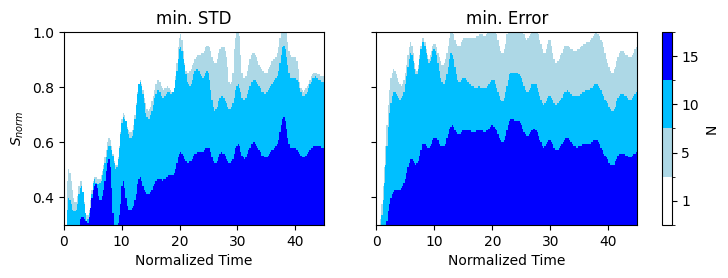

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2.5), sharex=True, sharey=True)

# ---------- subplot (a): min STD ----------
map_std = (
    p5_res_3d['bool_std1'].astype(int)
  + p10_res_3d['bool_std1'].astype(int)
  + p15_res_3d['bool_std1'].astype(int)
)

im0 = axs[0].imshow(
    map_std,
    origin='lower',
    extent=(p5_res_3d['t_min'], p5_res_3d['t_max'],
            p5_res_3d['ratio_m_s'][0], p5_res_3d['ratio_m_s'][-1]),
    aspect='auto',
    interpolation='nearest',
    cmap=cmap,
    norm=norm,
)

axs[0].set_title('min. STD')
axs[0].set_ylabel(r"$S_{norm}$", fontsize=10)
axs[0].set_xlabel("Normalized Time", fontsize=10)


# ---------- subplot (b): min Error ----------
map_err = (
    p5_res_3d['bool_ae1'].astype(int)
  + p10_res_3d['bool_ae1'].astype(int)
  + p15_res_3d['bool_ae1'].astype(int)
)

im1 = axs[1].imshow(
    map_err,
    origin='lower',
    extent=(p5_res_3d['t_min'], p5_res_3d['t_max'],
            p5_res_3d['ratio_m_s'][0], p5_res_3d['ratio_m_s'][-1]),
    aspect='auto',
    interpolation='nearest',
    cmap=cmap,
    norm=norm,
)

axs[1].set_title('min. Error')
axs[1].set_xlabel("Normalized Time", fontsize=10)


# ---------- shared colorbar ----------
cbar = fig.colorbar(
    im1,
    ax=axs,
    ticks=np.arange(len(colors)),
    fraction=0.035,
    pad=0.04,
    label='N'
)

cbar.ax.set_yticklabels([
    '1',
    '5',
    '10',
    '15'
])


[Text(1, 0, '1'), Text(1, 1, '5'), Text(1, 2, '10'), Text(1, 3, '15')]

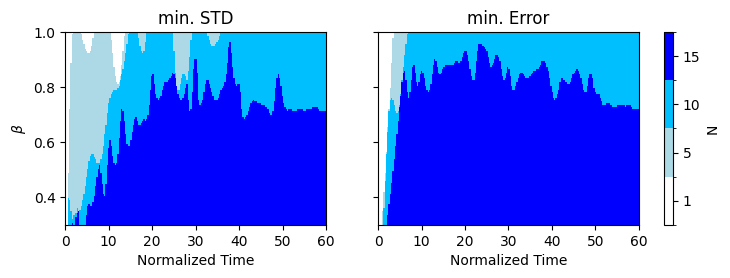

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2.5), sharex=True, sharey=True)

# ---------- subplot (a): min STD ----------
map_std = (
    p5_res1_3d['bool_std1'].astype(int)
  + p10_res1_3d['bool_std1'].astype(int)
  + p15_res1_3d['bool_std1'].astype(int)
)

im0 = axs[0].imshow(
    map_std,
    origin='lower',
    extent=(p5_res1_3d['t_min'], p5_res1_3d['t_max'],
            p5_res1_3d['beta'][0], p5_res1_3d['beta'][-1]),
    aspect='auto',
    interpolation='nearest',
    cmap=cmap,
    norm=norm,
)

axs[0].set_title('min. STD')
axs[0].set_ylabel(r"$\beta$", fontsize=10)
axs[0].set_xlabel("Normalized Time", fontsize=10)


# ---------- subplot (b): min Error ----------
map_err = (
    p5_res1_3d['bool_ae1'].astype(int)
  + p10_res1_3d['bool_ae1'].astype(int)
  + p15_res1_3d['bool_ae1'].astype(int)
)

im1 = axs[1].imshow(
    map_err,
    origin='lower',
    extent=(p5_res1_3d['t_min'], p5_res1_3d['t_max'],
            p5_res1_3d['beta'][0], p5_res1_3d['beta'][-1]),
    aspect='auto',
    interpolation='nearest',
    cmap=cmap,
    norm=norm,
)

axs[1].set_title('min. Error')
axs[1].set_xlabel("Normalized Time", fontsize=10)


# ---------- shared colorbar ----------
cbar = fig.colorbar(
    im1,
    ax=axs,
    ticks=np.arange(len(colors)),
    fraction=0.035,
    pad=0.04,
    label='N'
)

cbar.ax.set_yticklabels([
    '1',
    '5',
    '10',
    '15'
])


[Text(1, 0, '1'), Text(1, 1, '5'), Text(1, 2, '10'), Text(1, 3, '15')]

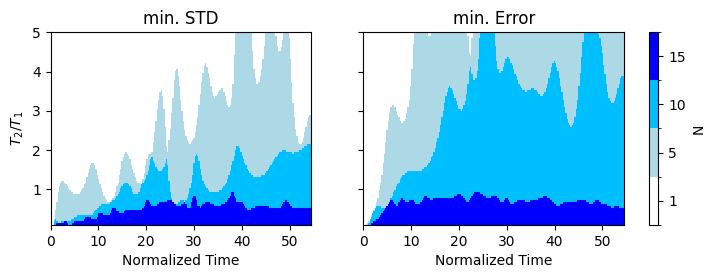

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2.5), sharex=True, sharey=True)

# ---------- subplot (a): min STD ----------
map_std = (
    p5_res2_3d['bool_std1'].astype(int)
  + p10_res2_3d['bool_std1'].astype(int)
  + p15_res2_3d['bool_std1'].astype(int)
)

im0 = axs[0].imshow(
    map_std,
    origin='lower',
    extent=(p5_res2_3d['t_min'], p5_res2_3d['t_max'],
            p5_res2_3d['dt'][0], p5_res2_3d['dt'][-1]),
    aspect='auto',
    interpolation='nearest',
    cmap=cmap,
    norm=norm,
)

axs[0].set_title('min. STD')
axs[0].set_ylabel(r"$T_2/T_1$", fontsize=10)
axs[0].set_xlabel("Normalized Time", fontsize=10)


# ---------- subplot (b): min Error ----------
map_err = (
    p5_res2_3d['bool_ae1'].astype(int)
  + p10_res2_3d['bool_ae1'].astype(int)
  + p15_res2_3d['bool_ae1'].astype(int)
)

im1 = axs[1].imshow(
    map_err,
    origin='lower',
    extent=(p5_res2_3d['t_min'], p5_res2_3d['t_max'],
            p5_res2_3d['dt'][0], p5_res2_3d['dt'][-1]),
    aspect='auto',
    interpolation='nearest',
    cmap=cmap,
    norm=norm,
)

axs[1].set_title('min. Error')
axs[1].set_xlabel("Normalized Time", fontsize=10)


# ---------- shared colorbar ----------
cbar = fig.colorbar(
    im1,
    ax=axs,
    ticks=np.arange(len(colors)),
    fraction=0.035,
    pad=0.04,
    label='N'
)

cbar.ax.set_yticklabels([
    '1',
    '5',
    '10',
    '15'
])


Text(3, 0.85, '$T_2/T_1=1$')

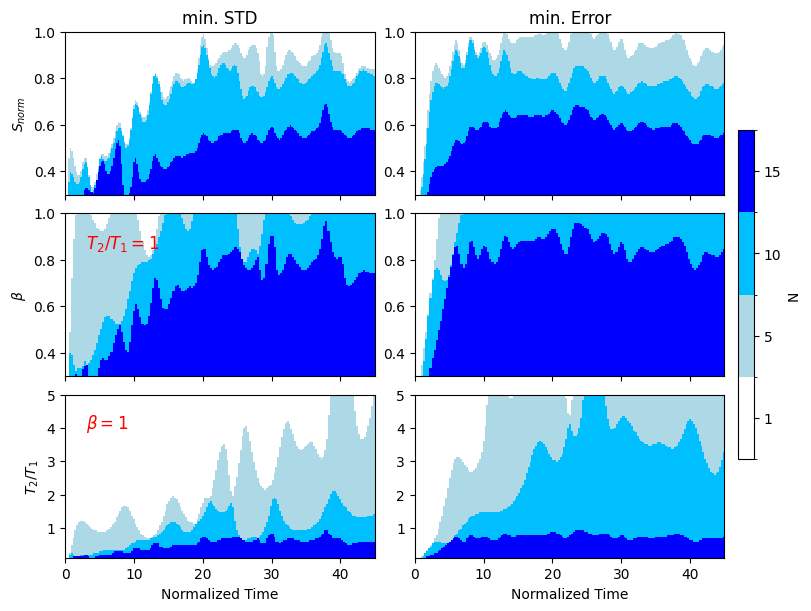

In [ ]:
fig, axs = plt.subplots(
    3, 2,
    figsize=(8, 6),
    sharex=True,
    constrained_layout=True
)

datasets = [
    # row 0
    dict(
        p5=p5_res_3d, p10=p10_res_3d, p15=p15_res_3d,
        y0=p5_res_3d['ratio_m_s'][0],
        y1=p5_res_3d['ratio_m_s'][-1],
        ylabel=r"$S_{norm}$"
    ),
    # row 1
    dict(
        p5=p5_res1_3d, p10=p10_res1_3d, p15=p15_res1_3d,
        y0=p5_res1_3d['beta'][0],
        y1=p5_res1_3d['beta'][-1],
        ylabel=r"$\beta$"
    ),
    # row 2
    dict(
        p5=p5_res2_3d, p10=p10_res2_3d, p15=p15_res2_3d,
        y0=p5_res2_3d['dt'][0],
        y1=p5_res2_3d['dt'][-1],
        ylabel=r"$T_2/T_1$"
    ),
]

for i, d in enumerate(datasets):

    # ---- min STD (left column) ----
    map_std = (
        d['p5']['bool_std1'].astype(int)
      + d['p10']['bool_std1'].astype(int)
      + d['p15']['bool_std1'].astype(int)
    )

    im = axs[i, 0].imshow(
        map_std,
        origin='lower',
        extent=(d['p5']['t_min'], d['p5']['t_max'], d['y0'], d['y1']),
        interpolation='nearest',
        aspect='auto',
        cmap=cmap,
        norm=norm
    )

    axs[i, 0].set_ylabel(d['ylabel'], fontsize=10)
    axs[i, 0].set_title('min. STD' if i == 0 else "")
    axs[i, 0].set_xlim(
    datasets[0]['p5']['t_min'],
    datasets[0]['p5']['t_max'])

    # ---- min Error (right column) ----
    map_err = (
        d['p5']['bool_ae1'].astype(int)
      + d['p10']['bool_ae1'].astype(int)
      + d['p15']['bool_ae1'].astype(int)
    )

    axs[i, 1].imshow(
        map_err,
        origin='lower',
        extent=(d['p5']['t_min'], d['p5']['t_max'], d['y0'], d['y1']),
        interpolation='nearest',
        aspect='auto',
        cmap=cmap,
        norm=norm
    )

    axs[i, 1].set_title('min. Error' if i == 0 else "")
    axs[i, 1].set_xlim(
    datasets[0]['p5']['t_min'],
    datasets[0]['p5']['t_max'])

# ---- shared x-labels ----
for ax in axs[-1, :]:
    ax.set_xlabel("Normalized Time", fontsize=10)

# ---- single shared colorbar ----
cbar = fig.colorbar(
    im,
    ax=axs,
    ticks=np.arange(len(colors)),
    fraction=0.025,
    pad=0.02,
    label='N'
)

cbar.ax.set_yticklabels(['1', '5', '10', '15'])

axs[2,0].text(3, 4, r'$\beta=1$', fontsize=12, c='r')
axs[1,0].text(3, .85, r'$T_2/T_1=1$', fontsize=12, c='r')


# 4D

In [ ]:
colors = ["w", "mistyrose", "salmon", "r",]
          #"#ff7f00", "#ffff33"]

cmap1 = ListedColormap(colors)
bounds = np.arange(len(colors)+1) - 0.5
norm = BoundaryNorm(bounds, cmap.N)

In [ ]:
p5 = load_hdf5_to_dict(folder + 'exp6_N4.h5')
p15 = load_hdf5_to_dict(folder + 'exp4_N4.h5')
p30 = load_hdf5_to_dict(folder + 'exp5_N4.h5')

In [ ]:
p5_res = compute_bo_comparison(p5, tol=0.02, n_interp=200)
p15_res = compute_bo_comparison(p15, tol=0.02, n_interp=200)
p30_res = compute_bo_comparison(p30, tol=0.02, n_interp=200)

p5_res1 = compute_bo_comparison(p5, tol=0.02, n_interp=200, ratio='beta')
p15_res1 = compute_bo_comparison(p15, tol=0.02, n_interp=200, ratio='beta')
p30_res1 = compute_bo_comparison(p30, tol=0.02, n_interp=200, ratio='beta')

p5_res2 = compute_bo_comparison(p5, tol=0.02, n_interp=200, ratio='dt')
p15_res2 = compute_bo_comparison(p15, tol=0.02, n_interp=200, ratio='dt')
p30_res2 = compute_bo_comparison(p30, tol=0.02, n_interp=200, ratio='dt')

In [ ]:
stack = np.stack([np.zeros(p5_res['bool_std1'].shape), p5_res['bool_std1'], p15_res['bool_std1'], p30_res['bool_std1']], axis=0)
max_map = np.max(stack, axis=0)
winner_std = np.argmax(stack, axis=0)

stack = np.stack([np.zeros(p5_res['bool_ae'].shape), p5_res['bool_ae'], p15_res['bool_ae'], p30_res['bool_ae']], axis=0)
max_map = np.max(stack, axis=0)
winner_ae = np.argmax(stack, axis=0)

[Text(1, 0, '1'), Text(1, 1, '5'), Text(1, 2, '10'), Text(1, 3, '15')]

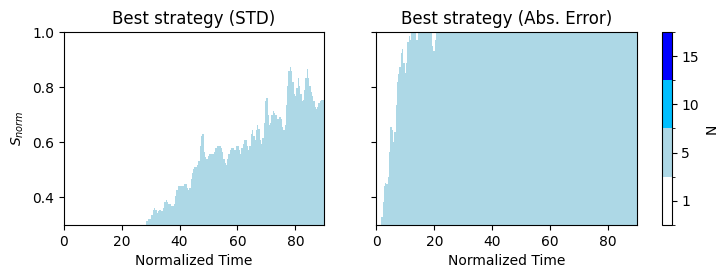

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2.5), sharex=True, sharey=True)

# ---------- subplot (a): min STD ----------


im0 = axs[0].imshow(
    winner_std,
    origin='lower',
    extent=(p5_res['t_min'], p5_res['t_max'],
            p5_res['ratio_m_s'][0], p5_res['ratio_m_s'][-1]),
    aspect='auto',
    interpolation='nearest',
    cmap=cmap,
    norm=norm,
)

axs[0].set_title('Best strategy (STD)')
axs[0].set_ylabel(r"$S_{norm}$", fontsize=10)
axs[0].set_xlabel("Normalized Time", fontsize=10)


# ---------- subplot (b): min Error ----------

im1 = axs[1].imshow(
    winner_ae,
    origin='lower',
    extent=(p5_res['t_min'], p5_res['t_max'],
            p5_res['ratio_m_s'][0], p5_res['ratio_m_s'][-1]),
    aspect='auto',
    interpolation='nearest',
    cmap=cmap,
    norm=norm,
)

axs[1].set_title('Best strategy (Abs. Error)')
axs[1].set_xlabel("Normalized Time", fontsize=10)


# ---------- shared colorbar ----------
cbar = fig.colorbar(
    im1,
    ax=axs,
    ticks=np.arange(len(colors)),
    fraction=0.035,
    pad=0.04,
    label='N'
)

cbar.ax.set_yticklabels([
    '1',
    '5',
    '10',
    '15'
])


[Text(1, 0, '1'), Text(1, 1, '5'), Text(1, 2, '15'), Text(1, 3, '30')]

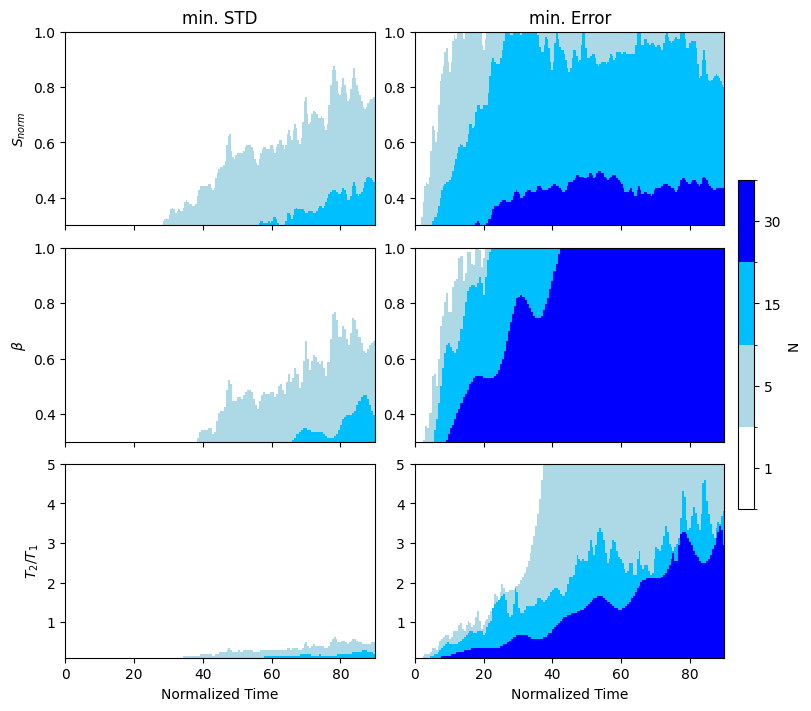

In [ ]:
fig, axs = plt.subplots(
    3, 2,
    figsize=(8, 7),
    sharex=True,
    constrained_layout=True
)

datasets = [
    dict(
        p5=p5_res, p15=p15_res, p30=p30_res,
        y0=p5_res['ratio_m_s'][0],
        y1=p5_res['ratio_m_s'][-1],
        ylabel=r"$S_{norm}$"
    ),
    dict(
        p5=p5_res1, p15=p15_res1, p30=p30_res1,
        y0=p5_res1['beta'][0],
        y1=p5_res1['beta'][-1],
        ylabel=r"$\beta$"
    ),
    dict(
        p5=p5_res2, p15=p15_res2, p30=p30_res2,
        y0=p5_res2['dt'][0],
        y1=p5_res2['dt'][-1],
        ylabel=r"$T_2/T_1$"
    ),
]

for i, d in enumerate(datasets):

    # ---------- min STD ----------
    map_std = (
        d['p5']['bool_std1'].astype(int)
      + d['p15']['bool_std1'].astype(int)
      + d['p30']['bool_std1'].astype(int)
    )

    im = axs[i, 0].imshow(
        map_std,
        origin='lower',
        extent=(d['p5']['t_min'], d['p5']['t_max'], d['y0'], d['y1']),
        interpolation='nearest',
        aspect='auto',
        cmap=cmap,
        norm=norm
    )

    axs[i, 0].set_ylabel(d['ylabel'], fontsize=10)
    axs[i, 0].set_title('min. STD' if i == 0 else "")
    axs[i, 0].set_xlim(
    datasets[0]['p5']['t_min'],
    datasets[0]['p5']['t_max'])

    # ---------- min Error ----------
    map_err = (
        d['p5']['bool_ae1'].astype(int)
      + d['p15']['bool_ae1'].astype(int)
      + d['p30']['bool_ae1'].astype(int)
    )

    axs[i, 1].imshow(
        map_err,
        origin='lower',
        extent=(d['p5']['t_min'], d['p5']['t_max'], d['y0'], d['y1']),
        interpolation='nearest',
        aspect='auto',
        cmap=cmap,
        norm=norm
    )

    axs[i, 1].set_title('min. Error' if i == 0 else "")
    axs[i, 1].set_xlim(
    datasets[0]['p5']['t_min'],
    datasets[0]['p5']['t_max'])

# ---------- x-labels ----------
for ax in axs[-1, :]:
    ax.set_xlabel("Normalized Time", fontsize=10)

# ---------- shared colorbar ----------
cbar = fig.colorbar(
    im,
    ax=axs,
    ticks=np.arange(len(colors)),
    fraction=0.025,
    pad=0.02,
    label='N'
)

cbar.ax.set_yticklabels(['1', '5', '15', '30'])


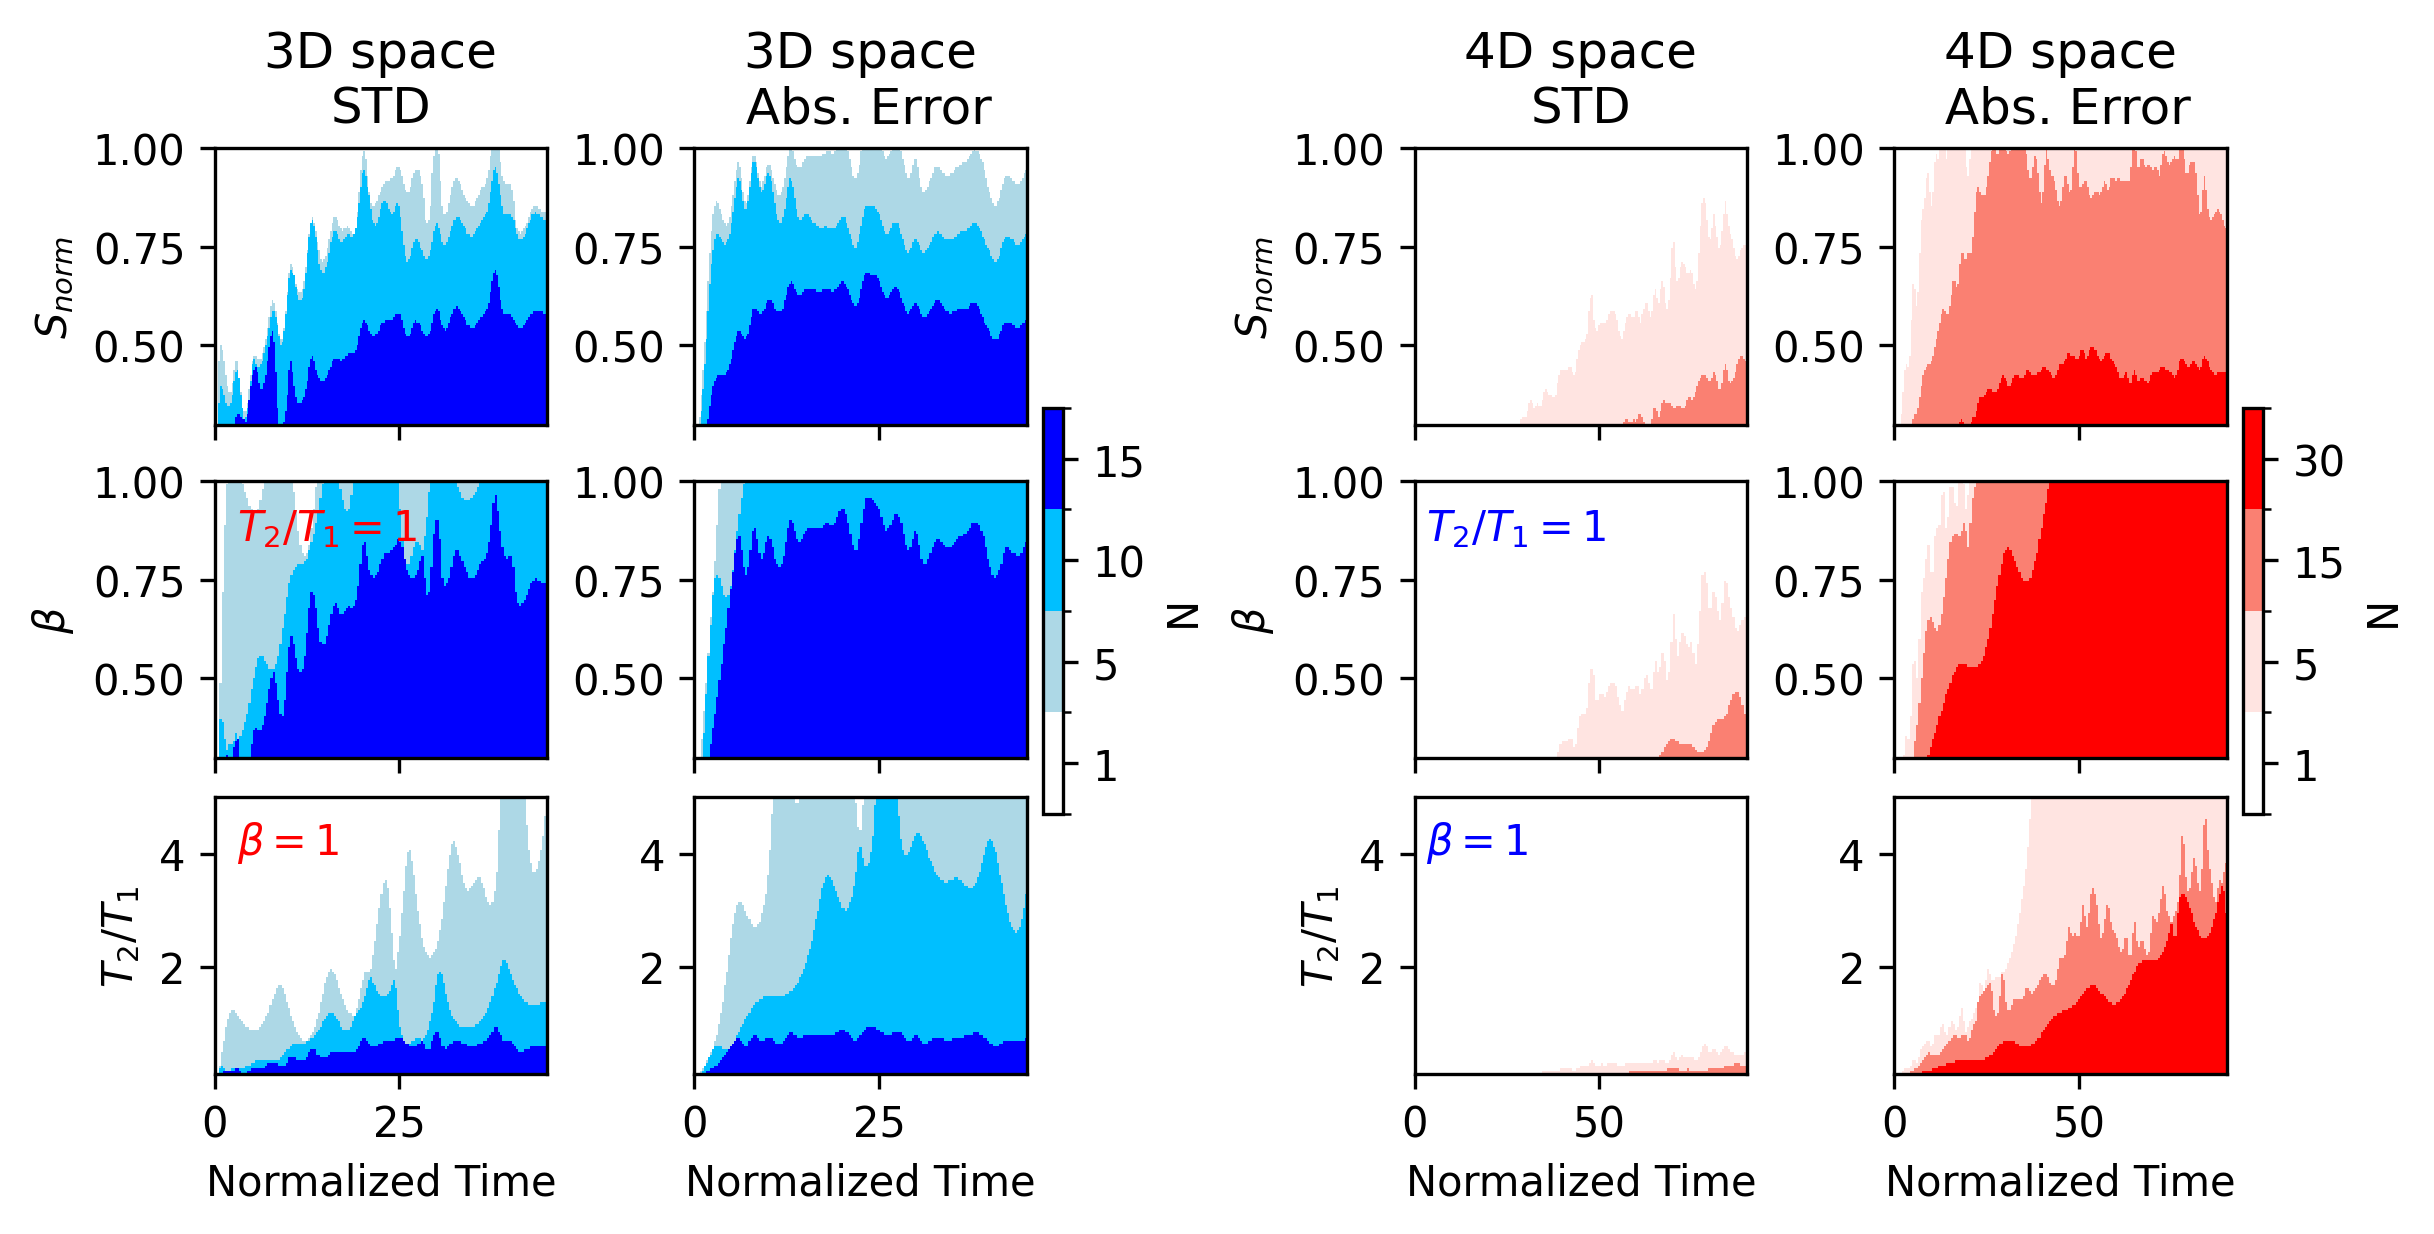

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(
    3, 4,
    figsize=(8, 4),
    sharex='col',     # share x within each column
    constrained_layout=True,
    dpi=300
)

# -------------------- helper --------------------
def draw_block(axs_block, datasets_block, Ns_labels, block_title, cmap):
    """
    axs_block: shape (3,2) -> columns: [min STD, min Error]
    datasets_block: list of 3 dicts, each with keys pA, pB, pC, y0,y1,ylabel
    Ns_labels: list of tick labels for the colorbar (e.g., ['1','5','10','15'])
    block_title: string for top row titles ("3D space" / "4D space")
    """
    im_last = None
    for i, d in enumerate(datasets_block):

        # ---- min STD (col 0) ----
        map_std = (
            d['pA']['bool_std1'].astype(int)
          + d['pB']['bool_std1'].astype(int)
          + d['pC']['bool_std1'].astype(int)
        )
        im0 = axs_block[i, 0].imshow(
            map_std,
            origin='lower',
            extent=(d['pA']['t_min'], d['pA']['t_max'], d['y0'], d['y1']),
            interpolation='nearest',
            aspect='auto',
            cmap=cmap,
            norm=norm
        )
        im_last = im0
        axs_block[i, 0].set_ylabel(d['ylabel'], fontsize=10)

        # ---- min Error (col 1) ----
        map_err = (
            d['pA']['bool_ae1'].astype(int)
          + d['pB']['bool_ae1'].astype(int)
          + d['pC']['bool_ae1'].astype(int)
        )
        axs_block[i, 1].imshow(
            map_err,
            origin='lower',
            extent=(d['pA']['t_min'], d['pA']['t_max'], d['y0'], d['y1']),
            interpolation='nearest',
            aspect='auto',
            cmap=cmap,
            norm=norm
        )

        # consistent x-limits from the first dataset row
        for j in [0, 1]:
            axs_block[i, j].set_xlim(datasets_block[0]['pA']['t_min'],
                                     datasets_block[0]['pA']['t_max'])

    # titles: top row only
    axs_block[0, 0].set_title(f"{block_title}\nSTD")
    axs_block[0, 1].set_title(f"{block_title}\n Abs. Error")

    # x-labels: bottom row only
    axs_block[2, 0].set_xlabel("Normalized Time", fontsize=10)
    axs_block[2, 1].set_xlabel("Normalized Time", fontsize=10)

    # colorbar for this block (ticks depend on Ns_labels)
    cbar = fig.colorbar(
        im_last,
        ax=axs_block,
        ticks=np.arange(len(colors)),
        fraction=0.025,
        pad=0.02,
        label='N'
    )
    cbar.ax.set_yticklabels(Ns_labels)

    return cbar

# -------------------- datasets: 3D space (cols 0-1) --------------------
datasets_3D = [
    dict(pA=p5_res_3d,  pB=p10_res_3d,  pC=p15_res_3d,
         y0=p5_res_3d['ratio_m_s'][0], y1=p5_res_3d['ratio_m_s'][-1], ylabel=r"$S_{norm}$"),
    dict(pA=p5_res1_3d, pB=p10_res1_3d, pC=p15_res1_3d,
         y0=p5_res1_3d['beta'][0],     y1=p5_res1_3d['beta'][-1],     ylabel=r"$\beta$"),
    dict(pA=p5_res2_3d, pB=p10_res2_3d, pC=p15_res2_3d,
         y0=p5_res2_3d['dt'][0],       y1=p5_res2_3d['dt'][-1],       ylabel=r"$T_2/T_1$"),
]

# -------------------- datasets: 4D space (cols 2-3) --------------------
datasets_4D = [
    dict(pA=p5_res,  pB=p15_res,  pC=p30_res,
         y0=p5_res['ratio_m_s'][0], y1=p5_res['ratio_m_s'][-1], ylabel=r"$S_{norm}$"),
    dict(pA=p5_res1, pB=p15_res1, pC=p30_res1,
         y0=p5_res1['beta'][0],     y1=p5_res1['beta'][-1],     ylabel=r"$\beta$"),
    dict(pA=p5_res2, pB=p15_res2, pC=p30_res2,
         y0=p5_res2['dt'][0],       y1=p5_res2['dt'][-1],       ylabel=r"$T_2/T_1$"),
]

# -------------------- draw blocks --------------------
axs_3D = axs[:, 0:2]
axs_4D = axs[:, 2:4]

cbar3D = draw_block(axs_3D, datasets_3D, Ns_labels=['1','5','10','15'], block_title="3D space", cmap=cmap)
cbar4D = draw_block(axs_4D, datasets_4D, Ns_labels=['1','5','15','30'], block_title="4D space", cmap=cmap1)

# -------------------- your annotations (put them on the correct axes) --------------------
# These were originally on the 3D figure. Adjust coordinates as needed.
axs_3D[2, 0].text(3, 4, r'$\beta=1$', fontsize=10, c='r')
axs_3D[1, 0].text(3, .85, r'$T_2/T_1=1$', fontsize=10, c='r')

axs_4D[2, 0].text(3, 4, r'$\beta=1$', fontsize=10, c='b')
axs_4D[1, 0].text(3, .85, r'$T_2/T_1=1$', fontsize=10, c='b')

fig.savefig('fig3.jpg', dpi=300, bbox_inches='tight')


In [ ]:
map_std = p5_res['bool_std1'].astype(int)+ p15_res['bool_std1'].astype(int)+ p30_res['bool_std1'].astype(int)


fig = plt.subplots(figsize=(5,3))

plt.imshow(map_std,
           origin='lower',
           extent = (p5_res['t_min'], p5_res['t_max'],
                     p5_res['ratio_m_s'][0], p5_res['ratio_m_s'][-1]),
           aspect='auto',
           interpolation='nearest',
           cmap=cmap, norm=norm,
           )
cb = plt.colorbar(ticks=np.arange(len(colors)))
cb.ax.set_yticklabels(['1-by-1', '5 p. in m-d', '10 p. in m-d', '15 p. in m-d'])

plt.ylabel("$R_{M/S}$", fontsize=10)
plt.xlabel("Normalized Time", fontsize=10)

plt.title('$\Delta STD$')

In [ ]:
map_std = p5_res['bool_ae1'].astype(int)+ p15_res['bool_ae1'].astype(int)+ p30_res['bool_ae1'].astype(int)


fig = plt.subplots(figsize=(5,3))

plt.imshow(map_std,
           origin='lower',
           extent = (p5_res['t_min'], p5_res['t_max'],
                     p5_res['ratio_m_s'][0], p5_res['ratio_m_s'][-1]),
           aspect='auto',
           interpolation='nearest',
           cmap=cmap, norm=norm,
           )
cb = plt.colorbar(ticks=np.arange(len(colors)))
cb.ax.set_yticklabels(['1-by-1', '5 p. in m-d', '10 p. in m-d', '15 p. in m-d'])

plt.ylabel("$R_{M/S}$", fontsize=10)
plt.xlabel("Normalized Time", fontsize=10)

plt.title('$\Delta Abs. Error$')

In [ ]:
dt = np.linspace(0.1, 10, 100)
beta = np.linspace(0.3, 1, 100)

dt_grid, beta_grid = np.meshgrid(dt, beta, indexing='ij')

pairs = np.column_stack([dt_grid.ravel(), beta_grid.ravel()])
mins, maxs = pairs.min(axis=0), pairs.max(axis=0)

def factor(dt, beta, N=10, alpha=1):
  return (alpha + beta*N*dt)/(1 + dt)


In [ ]:
fctr = factor(*pairs.T, N=10)

fctr2 = fctr.reshape(100,100)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8,2.5))

im = ax[2].imshow(
    fctr2 / 10,
    origin='lower',
    extent=(mins[0], maxs[0], mins[1], maxs[1])
)

# add contours at identical value levels
levels = np.linspace((fctr2/10).min(), (fctr2/10).max(), 6)

cs = ax[2].contour(
    fctr2 / 10,
    levels=levels,
    colors='white',
    linewidths=0.8,
    origin='lower',
    extent=(mins[0], maxs[0], mins[1], maxs[1])
)

ax[2].clabel(cs, inline=True, fontsize=8)

ax[2].set_aspect('auto')
plt.colorbar(im, ax=ax[2])


ax[1].plot(dt, factor(dt, 0.3)/10, label=r'0.3', c='b')
ax[1].plot(dt, factor(dt, 0.7)/10, label=r'0.7', c='g')
ax[1].plot(dt, factor(dt, 1)/10, label=r'1', c='r')
ax[1].legend(title=r'$\beta$', fontsize=9)

ax[0].plot(beta, factor(0.1, beta)/10, label=r'0.1', c='b')
ax[0].plot(beta, factor(1, beta)/10, label=r'1', c='g')
ax[0].plot(beta, factor(10, beta)/10, label=r'10', c='r')
ax[0].legend(title=r'$T_2/T_1$', fontsize=9)


ax[2].set_ylabel(r'$\beta$')
ax[2].set_xlabel(r'$T_2/T_1$')

ax[1].set_xlabel(r'$T_2/T_1$')
ax[0].set_xlabel(r'$\beta$')

fig.suptitle('Normalized speed-up factor', y=.9)

plt.tight_layout()

fig.savefig('fig0.jpg', dpi=300, bbox_inches='tight')

In [ ]:
pairs.min(axis=0)